In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import requests

# https://stackoverflow.com/a/46574866/1574687
import matplotlib as mpl

from scipy import stats

from bs4 import BeautifulSoup

import seaborn as sb
sb.set_style('whitegrid')

import pandas as pd
pd.options.display.max_columns = 100
idx = pd.IndexSlice

import json, datetime, time, os, re

import networkx as nx
#from scipy.spatial import distance

from matplotlib import colors, cm

_dir = u'E:/Dropbox/Workspace/Wikipedia_Trump/'
#_dir = u'/Users/briankeegan/Dropbox/Workspace/Wikipedia BLM/'

In [2]:
pv_date_range = ('2015-07-01','2017-12-01')

start, stop = pd.Timestamp('2015-06-01',freq='D'), pd.Timestamp('2017-11-09',freq='D')

# Load data

### Bots

Load all the users who are categorized as bots.

In [3]:
with open('bots.json','r') as f:
    bot_list = json.load(f)
    
bot_list = [name[5:] for name in bot_list]

print("There are {0:,} bots.".format(len(bot_list)))

There are 1,712 bots.


### Revisions

Load all the revisions.

In [4]:
all_clinton_rev_df = pd.read_csv('all_clinton_page_revisions.csv',encoding='utf8',parse_dates=['date','timestamp'],
                         dtype={'parentid':str,'revid':str,'userid':str},low_memory=False)
all_trump_rev_df = pd.read_csv('all_trump_page_revisions.csv',encoding='utf8',parse_dates=['date','timestamp'],
                         dtype={'parentid':str,'revid':str,'userid':str},low_memory=False)

all_trump_rev_df.head()

,anon,comment,commenthidden,date,page,parentid,revid,sha1,sha1hidden,size,suppressed,timestamp,user,userhidden,userid,year,month,size_diff,prev_user,rev_index,age,latency
0,False,NaN,NaN,2016-07-30,/r/The Donald,0,732214190,4e740bd73bb2774f20bd07e47c82aecef915d2db,NaN,42,NaN,2016-07-30 11:42:31,Nyuszika7H,NaN,0,2016,7,NaN,NaN,0,0.0,NaN
1,False,NaN,NaN,2016-07-30,/r/The Donald,732214190,732214592,2f0d2e463baf26803e343652b3f9bf5cfed3d552,NaN,87,NaN,2016-07-30 11:46:38,Nyuszika7H,NaN,0,2016,7,45.0,Nyuszika7H,1,0.0,247.0
2,False,NaN,NaN,2016-09-16,/r/The Donald,732214592,739695016,399fd716f6bea87cfe8d4378d8bca16f4fcfece3,NaN,139,NaN,2016-09-16 11:13:20,RussBot,NaN,0,2016,9,52.0,Nyuszika7H,2,48.0,4145202.0
3,False,NaN,NaN,2016-10-08,/r/The Donald,739695016,743240915,1aca16fca4e79cf715ce3970edebafaebec922a4,NaN,223,NaN,2016-10-08 18:38:31,Paine Ellsworth,NaN,0,2016,10,84.0,RussBot,3,70.0,1927511.0
4,False,NaN,NaN,2016-11-24,/r/The Donald,743240915,751319407,b7e9a0ae82d2f2337c03c10adbebcee2e7b0c3f2,NaN,5309,NaN,2016-11-24 21:31:53,Yoshiman6464,NaN,0,2016,11,5086.0,Paine Ellsworth,4,117.0,4071202.0


How many total revisions?

In [5]:
_clinton_total_rev_count = len(all_clinton_rev_df)
_trump_total_rev_count = len(all_trump_rev_df)

print("There are {0:,} revisions in the \"Hillary Clinton\" dataset".format(_clinton_total_rev_count))
print("There are {0:,} revisions pages in the \"Donald Trump\" dataset".format(_trump_total_rev_count))

There are 375,315 revisions in the "Hillary Clinton" dataset
There are 366,268 revisions pages in the "Donald Trump" dataset


How many during the campaign?

In [6]:
_clinton_campaign_rev_count = len(all_clinton_rev_df[(all_clinton_rev_df['date'] > pd.Timestamp('2015-01-01',freq='D')) & (all_clinton_rev_df['date'] < pd.Timestamp('2016-11-08',freq='D'))])
_trump_campaign_rev_count = len(all_trump_rev_df[(all_trump_rev_df['date'] > pd.Timestamp('2015-01-01',freq='D')) & (all_trump_rev_df['date'] < pd.Timestamp('2016-11-08',freq='D'))])

print("There are {0:,} revisions ({1:.1%}) in the \"Hillary Clinton\" dataset during the campaign".format(_clinton_campaign_rev_count,_clinton_campaign_rev_count/_clinton_total_rev_count))
print("There are {0:,} revisions ({1:.1%}) pages in the \"Donald Trump\" dataset during the campaign".format(_trump_campaign_rev_count,_trump_campaign_rev_count/_trump_total_rev_count))

There are 57,944 revisions (15.4%) in the "Hillary Clinton" dataset during the campaign
There are 77,110 revisions (21.1%) pages in the "Donald Trump" dataset during the campaign


How many unique users?

In [7]:
_clinton_total_user_count = len(all_clinton_rev_df['user'].unique())
_trump_total_user_count = len(all_trump_rev_df['user'].unique())

print("There are {0:,} unique users in the \"Hillary Clinton\" dataset".format(_clinton_total_user_count))
print("There are {0:,} unique users in the \"Donald Trump\" dataset".format(_trump_total_user_count))

There are 93,012 unique users in the "Hillary Clinton" dataset
There are 67,643 unique users in the "Donald Trump" dataset


How many articles are there for each candidate?

In [8]:
print("There are {0:,} unique pages in the \"Hillary Clinton\" dataset".format(len(all_clinton_rev_df['page'].unique())))
print("There are {0:,} unique pages in the \"Donald Trump\" dataset".format(len(all_trump_rev_df['page'].unique())))

There are 1,336 unique pages in the "Hillary Clinton" dataset
There are 949 unique pages in the "Donald Trump" dataset


Subset to only revision on the Donald Trump and Hillary Clinton articles.

In [9]:
clinton_rev_df = all_clinton_rev_df[all_clinton_rev_df['page'] == "Hillary Clinton"]
trump_rev_df = all_trump_rev_df[all_trump_rev_df['page'] == "Donald Trump"]

clinton_campaign_rev_df = clinton_rev_df[(clinton_rev_df['date'] > start) & (clinton_rev_df['date'] < stop)]
trump_campaign_rev_df = trump_rev_df[(trump_rev_df['date'] > start) & (trump_rev_df['date'] < stop)]

print("There are {0:,} revisions on the \"Hillary Clinton\" article over the year preceding and following the election".format(len(clinton_campaign_rev_df)))
print("There are {0:,} revisions on the \"Donald Trump\" article over the year preceding and following the election\n".format(len(trump_campaign_rev_df)))

There are 3,237 revisions on the "Hillary Clinton" article over the year preceding and following the election
There are 15,908 revisions on the "Donald Trump" article over the year preceding and following the election



Unique users?

In [10]:
print("There are {0:,} unique users on the \"Hillary Clinton\" article".format(len(clinton_rev_df['user'].unique())))
print("There are {0:,} unique users on the \"Donald Trump\" article\n".format(len(trump_rev_df['user'].unique())))

print("There are {0:,} unique users on the \"Hillary Clinton\" article over the year preceding and following the election".format(len(clinton_campaign_rev_df['user'].unique())))
print("There are {0:,} unique users on the \"Donald Trump\" article over the year preceding and following the election".format(len(trump_campaign_rev_df['user'].unique())))


There are 4,354 unique users on the "Hillary Clinton" article
There are 5,452 unique users on the "Donald Trump" article

There are 823 unique users on the "Hillary Clinton" article over the year preceding and following the election
There are 2,195 unique users on the "Donald Trump" article over the year preceding and following the election


Load the median daily revisions.

In [11]:
with open('median_trump_revids.json','r') as f:
    median_trump_revids = json.load(f)

median_trump_revid_s = pd.Series(median_trump_revids)
median_trump_revid_s = median_trump_revid_s.reset_index().rename(columns = {'index':'date',0:'revid'})
median_trump_revid_s['date'] = pd.to_datetime(median_trump_revid_s['date'])
median_trump_revid_s['year'] = median_trump_revid_s['date'].apply(lambda x:x.year)
median_trump_revid_s['month'] = median_trump_revid_s['date'].apply(lambda x:x.month)

# https://stackoverflow.com/questions/15705630/python-getting-the-row-which-has-the-max-value-in-groups-using-groupby
annual_revids = median_trump_revid_s.loc[median_trump_revid_s.groupby(['year','month'])['date'].idxmax()].set_index(['year','month'])['revid']
annual_revids.head(13)

year  month
2004  1         2377232
      2         2924290
      3         3017884
      4         3415538
      5         3837531
      6         4995598
      8         5723197
      9         6353766
      10        7060579
      11        7950512
      12        8968175
2005  1         9942849
      2        10772183
Name: revid, dtype: object

### Pageviews

In [12]:
all_clinton_pv_df = pd.read_csv('all_clinton_pageviews_redirects.csv',encoding='utf8',parse_dates = [0],index_col=[0,1],header=[0,1],skiprows=[2], low_memory=False).sort_index()
all_trump_pv_df = pd.read_csv('all_trump_pageviews_redirects.csv',encoding='utf8',parse_dates = [0],index_col=[0,1],header=[0,1],skiprows=[2], low_memory=False).sort_index()

def cleanup_pv_df(pv_df):
    pv_df = pv_df.unstack(0).fillna(0)
    pv_df.index = pd.to_datetime(pv_df.index)
    pv_df = pv_df.reindex(pd.date_range('2015-07-01','2017-11-09'))
    pv_df = pv_df.stack(-1)
    pv_df = pv_df.swaplevel().sort_index(0)
    return pv_df

cleaned_clinton_pv_df = cleanup_pv_df(all_clinton_pv_df)
cleaned_trump_pv_df = cleanup_pv_df(all_trump_pv_df)

In [13]:
cleaned_clinton_pv_df.loc['Hillary Clinton',('all-agents','all-access')].head()

2015-07-01    13624.0
2015-07-02    12686.0
2015-07-03    11251.0
2015-07-04    10373.0
2015-07-05    11907.0
Freq: D, Name: (all-agents, all-access), dtype: float64

In [14]:
cleaned_trump_pv_df.loc['Donald Trump',('all-agents','all-access')].head()

2015-07-01    89519.0
2015-07-02    90804.0
2015-07-03    60450.0
2015-07-04    47489.0
2015-07-05    45924.0
Freq: D, Name: (all-agents, all-access), dtype: float64

### Log events

In [15]:
all_clinton_le_df = pd.read_csv('all_clinton_logevents.csv',low_memory=False,parse_dates=['date','timestamp'])
all_trump_le_df = pd.read_csv('all_trump_logevents.csv',low_memory=False,parse_dates=['date','timestamp'])

clinton_article_le_df = all_clinton_le_df[all_clinton_le_df['redirect_page'] == "Hillary Clinton"]
trump_article_le_df = all_trump_le_df[all_trump_le_df['redirect_page'] == "Donald Trump"]

clinton_article_le_df.head()

,action,comment,commenthidden,date,logid,logpage,ns,page,pageid,tags,timestamp,title,type,user,userid,redirect_page
119,patrol,NaN,NaN,2015-04-30,65912051.0,46569183.0,0.0,Hilary Diane Rodham Clinton,46569183.0,[],2015-04-30 11:17:08,Hilary Diane Rodham Clinton,patrol,Rich Farmbrough,82835,Hillary Clinton
161,patrol,NaN,NaN,2015-04-30,65914631.0,46569502.0,0.0,"Clinton, Hilary",46569502.0,[],2015-04-30 12:15:41,"Clinton, Hilary",patrol,Rich Farmbrough,82835,Hillary Clinton
276,reviewed,NaN,NaN,2016-10-19,78154734.0,24199473.0,0.0,H. Clinton,24199473.0,[],2016-10-19 07:39:19,H. Clinton,pagetriage-curation,Ymblanter,14596827,Hillary Clinton
898,move,shorter,NaN,2006-06-02,2999042.0,0.0,0.0,Controversies surrounding Hillary Rodham Clinton,5398389.0,[],2006-06-02 22:29:00,Controversies surrounding Hillary Rodham Clinton,move,Savidan,677067,Hillary Clinton
1134,reviewed,NaN,NaN,2016-10-17,78107670.0,14178116.0,0.0,Hillary Diane,14178116.0,[],2016-10-17 08:10:16,Hillary Diane,pagetriage-curation,Ymblanter,14596827,Hillary Clinton


### Content

In [ ]:
monthly_content_d = {}

for (_year,_month),_revid in annual_revids.items():
    with open(_dir+"Data/Content/{0}.json".format(_revid),'r') as f:
        _json = json.load(f)
        monthly_content_d[(str(_year),str(_month))] = _json['content']

### Links

In [16]:
link_files = os.listdir(_dir+'Data/Links')
print("There are {0:,} link files.".format(len(link_files)))

link_file_d = {}

for lf in link_files:
    revid = lf[:-5]
    with open(_dir+'Data/Links/'+lf,'r') as f:
        link_file_d[revid] = json.load(f)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'E:/Dropbox/Workspace/Wikipedia_Trump/Data/Links'

### 538 chances

In [17]:
with open('chance_538_raw_d.txt','r') as f:
    chance_538_d = f.readlines()[0]

with open('chance_538_raw_r.txt','r') as f:
    chance_538_r = f.readlines()[0]

soup_d = BeautifulSoup(chance_538_d,'lxml')  
soup_r = BeautifulSoup(chance_538_r,'lxml')

(0, 100)

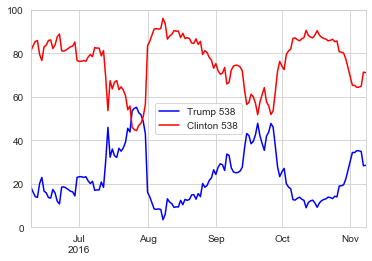

In [18]:
fte_clinton = pd.Series({np.float64(i.split('L')[1]):np.float64(i.split('L')[0])*(81.1/150.5) for i in soup_d.html.body.path['d'].split(',') if len(i.split('L')) > 1}).sort_index()
fte_trump = pd.Series({np.float64(i.split('L')[1]):np.float64(i.split('L')[0])*(81.1/150.5) for i in soup_r.html.body.path['d'].split(',') if len(i.split('L')) > 1}).sort_index()

fte_clinton.index = pd.date_range('2016-06-09','2016-11-08')
fte_trump.index = pd.date_range('2016-06-09','2016-11-08')

fte_df = pd.DataFrame({'Trump 538':fte_trump,'Clinton 538':fte_clinton})
fte_df.to_csv('fivethirtyeight_likelihood.csv')

ax = fte_df.plot(color=['b','r'])
ax.set_ylim((0,100))

### User contributions

In [19]:
with open('active_users_clinton.json','r') as f:
    clinton_active_user_list = json.load(f)
    
with open('active_users_trump.json','r') as f:
    trump_active_user_list = json.load(f)
    
with open('active_users_both.json','r') as f:
    both_active_user_list = json.load(f)
    
with open('userinfo_active_users_both.json','r') as f:
    both_active_userinfo = json.load(f)

In [20]:
all_user_contribs = pd.read_csv('active_user_contribs.csv',encoding='utf8',parse_dates=['timestamp','date'])

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (1,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Basic descriptives

### Revisions

In [21]:
daily_trump_revs = trump_rev_df.groupby('date').agg({'sha1':pd.Series.nunique,'size':np.median})
daily_trump_revs = daily_trump_revs.reindex(index=pd.date_range(daily_trump_revs.index.min(),
                                                                daily_trump_revs.index.max()))
daily_trump_revs['sha1'].fillna(0,inplace=True)
daily_trump_revs['size'].fillna(method='ffill',inplace=True)

daily_clinton_revs = clinton_rev_df.groupby('date').agg({'sha1':pd.Series.nunique,'size':np.median})
daily_clinton_revs = daily_clinton_revs.reindex(index=pd.date_range(daily_clinton_revs.index.min(),
                                                                    daily_clinton_revs.index.max()))
daily_clinton_revs['sha1'].fillna(0,inplace=True)
daily_clinton_revs['size'].fillna(method='ffill',inplace=True)

all_revs_min_ts = min(daily_trump_revs.index.min(),daily_clinton_revs.index.min())
all_revs_max_ts = min(daily_trump_revs.index.max(),daily_clinton_revs.index.max())

In [22]:
def ts_to_unix(ts):
    return (ts - pd.Timestamp('1970-01-01'))/np.timedelta64(1,'D')

def ts_frac(ts_val,ts_min = all_revs_min_ts, ts_max = all_revs_max_ts):
    val_as_unix_int = ts_to_unix(ts_val)
    min_as_unix_int = ts_to_unix(ts_min)
    max_as_unix_int = ts_to_unix(ts_max)
    return (val_as_unix_int - min_as_unix_int)/(max_as_unix_int - min_as_unix_int)

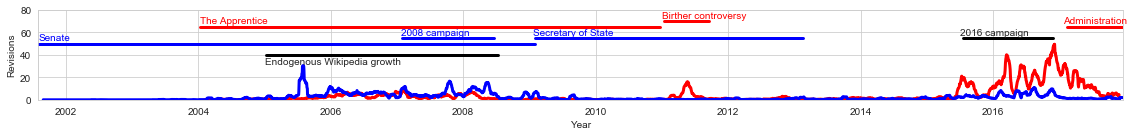

In [23]:
f,ax = plt.subplots(1,1,figsize=(16,2))

daily_trump_revs.rolling(28).mean()['sha1'].plot(lw=3,ax=ax,color='r',legend=False)
daily_clinton_revs.rolling(28).mean()['sha1'].plot(lw=3,ax=ax,color='b',legend=False)
ax.set_ylim((0,80))
ax.set_xlabel('Year')
ax.set_ylabel('Revisions')

# Endogenous Wikipedia growth
ax.axhline(y=40,xmin=ts_frac(pd.Timestamp('2005-01-01')),xmax=ts_frac(pd.Timestamp('2008-07-01')),color='k',lw=3)
ax.annotate("Endogenous Wikipedia growth", xy=(ts_to_unix(pd.Timestamp('2005-01-01')), 34), va="center", ha="left")

# Clinton as Senator
ax.axhline(y=50,xmin=ts_frac(all_revs_min_ts),xmax=ts_frac(pd.Timestamp('2009-01-21')),color='b',lw=3)
ax.annotate("Senate", xy=(ts_to_unix(all_revs_min_ts), 55), va="center", ha="left", color='b')

# Clinton 2008 campaign
ax.axhline(y=55,xmin=ts_frac(pd.Timestamp('2007-01-20')),xmax=ts_frac(pd.Timestamp('2008-06-07')),color='b',lw=3)
ax.annotate("2008 campaign", xy=(ts_to_unix(pd.Timestamp('2007-01-20')), 60), va="center", ha="left", color='b')

# Clinton as SoS
ax.axhline(y=55,xmin=ts_frac(pd.Timestamp('2009-01-21')),xmax=ts_frac(pd.Timestamp('2013-02-01')),color='b',lw=3)
ax.annotate("Secretary of State", xy=(ts_to_unix(pd.Timestamp('2009-01-21')), 60), va="center", ha="left", color='b')

# Trump on Apprentice
ax.axhline(y=65,xmin=ts_frac(pd.Timestamp('2004-01-08')),xmax=ts_frac(pd.Timestamp('2010-12-09')),color='r',lw=3)
ax.annotate("The Apprentice", xy=(ts_to_unix(pd.Timestamp('2004-01-08')), 70), va="center", ha="left", color='r')

# Trump Birther controversy
ax.axhline(y=70,xmin=ts_frac(pd.Timestamp('2011-01-01')),xmax=ts_frac(pd.Timestamp('2011-09-01')),color='r',lw=3)
ax.annotate("Birther controversy", xy=(ts_to_unix(pd.Timestamp('2011-01-01')), 75), va="center", ha="left", color='r')

# Presidential campaign
ax.axhline(y=55,xmin=ts_frac(pd.Timestamp('2015-07-01')),xmax=ts_frac(pd.Timestamp('2016-11-08')),color='k',lw=3)
ax.annotate("2016 campaign", xy=(ts_to_unix(pd.Timestamp('2015-07-01')), 60), va="center", ha="left")

# Presidential administration
ax.axhline(y=65,xmin=ts_frac(pd.Timestamp('2017-01-20')),xmax=ts_frac(all_revs_max_ts),color='r',lw=3)
ax.annotate("Administration", xy=(ts_to_unix(pd.Timestamp('2017-01-20')), 70), va="center", ha="left", color='r')

plt.tight_layout()
plt.savefig('article_revisions_max.pdf')

#ax.axvspan(pd.Timestamp('2001-01-03'),pd.Timestamp('2009-01-21'),color='b',alpha=.1) # Clinton's Senate tenure
#ax.axvspan(pd.Timestamp('2009-01-21'),pd.Timestamp('2013-02-01'),color='b',alpha=.1) # Clinton's SoS tenure
#ax.axvspan(pd.Timestamp('2011-01-01'),pd.Timestamp('2011-09-01'),color='r',alpha=.1) # Trump's Birther controversy
#ax.axvspan(pd.Timestamp('2015-07-01'),pd.Timestamp('2016-12-08'),color='k',alpha=.1) # 2016 presidential campaign
#ax.axvspan(pd.Timestamp('2017-02-26'),pd.Timestamp('2017-11-29'),color='r',alpha=.1) # Presidential administration

In [24]:
trump_daily_revs_max = daily_trump_revs.loc[:'2017-11-09']['sha1']
clinton_daily_revs_max = daily_clinton_revs.loc[:'2017-11-09']['sha1']

F,p_F = stats.f_oneway(trump_daily_revs_max.values,clinton_daily_revs_max.values)
H,p_H = stats.kruskal(trump_daily_revs_max.values,clinton_daily_revs_max.values)

print("Trump mean edits: {0:.1f} ± {1:.2f} (max. {2})\nClinton mean edits: {3:.1f} ± {4:.2f} (max {5})\nANOVA: {6:.2f} (p = {7:.3e})\n".format(trump_daily_revs_max.mean(),trump_daily_revs_max.std(),trump_daily_revs_max.max(),clinton_daily_revs_max.mean(),clinton_daily_revs_max.std(),clinton_daily_revs_max.max(),F,p_F))
print("Trump median edits: {0:.3f}\nClinton median edits: {1:.3f}\nKruskal-Wallis: {2:.2f} (p = {3:.3e})".format(trump_daily_revs_max.median(),clinton_daily_revs_max.median(),H,p_H))

Trump mean edits: 4.2 ± 9.63 (max. 155.0)
Clinton mean edits: 2.2 ± 5.84 (max 172.0)
ANOVA: 174.43 (p = 1.591e-39)

Trump median edits: 1.000
Clinton median edits: 0.000
Kruskal-Wallis: 105.66 (p = 8.745e-25)


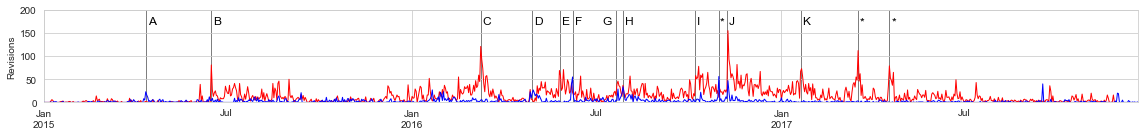

In [35]:
f,ax = plt.subplots(1,1,figsize=(16,2))
daily_trump_revs.loc[pd.Timestamp('2015-01-01'):]['sha1'].plot(lw=1,ax=ax,color='r',legend=False)
daily_clinton_revs.loc[pd.Timestamp('2015-01-01'):]['sha1'].plot(lw=1,ax=ax,color='b',legend=False)
ax.set_ylim((0,200))
#ax.set_yscale('symlog')
ax.set_xlabel('')
ax.set_ylabel('Revisions')

label_height = 175

ax.axvline(pd.Timestamp('2015-04-12'),color='k',zorder=-1,lw=.5) # Clinton Announcement
ax.annotate('A',xy=(ts_to_unix(pd.Timestamp('2015-04-14')),label_height),va="center", ha="left", color='k', size=12)

ax.axvline(pd.Timestamp('2015-06-16'),color='k',zorder=-1,lw=.5) # Trump Announcement
ax.annotate('B',xy=(ts_to_unix(pd.Timestamp('2015-06-18')),label_height),va="center", ha="left", color='k', size=12)

ax.axvline(pd.Timestamp('2016-03-09'),color='k',zorder=-1,lw=.5) # Super Tuesdays
ax.annotate('C',xy=(ts_to_unix(pd.Timestamp('2016-03-11')),label_height),va="center", ha="left", color='k', size=12)

ax.axvline(pd.Timestamp('2016-04-29'),color='k',zorder=-1,lw=.5) # Acela primary
ax.annotate('D',xy=(ts_to_unix(pd.Timestamp('2016-05-01')),label_height),va="center", ha="left", color='k', size=12)

ax.axvline(pd.Timestamp('2016-05-27'),color='k',zorder=-1,lw=.5) # Trump presumtive nominee
ax.annotate('E',xy=(ts_to_unix(pd.Timestamp('2016-05-29')),label_height),va="center", ha="left", color='k', size=12)

ax.axvline(pd.Timestamp('2016-06-08'),color='k',zorder=-1,lw=.5) # Clinton presumptive nominee
ax.annotate('F',xy=(ts_to_unix(pd.Timestamp('2016-06-10')),label_height),va="center", ha="left", color='k', size=12)

ax.axvline(pd.Timestamp('2016-07-21'),color='k',zorder=-1,lw=.5) # Republican National Convention
ax.annotate('G',xy=(ts_to_unix(pd.Timestamp('2016-07-08')),label_height),va="center", ha="left", color='k', size=12)

ax.axvline(pd.Timestamp('2016-07-28'),color='k',zorder=-1,lw=.5) # Democratic National convention
ax.annotate('H',xy=(ts_to_unix(pd.Timestamp('2016-07-30')),label_height),va="center", ha="left", color='k', size=12)

ax.axvline(pd.Timestamp('2016-10-07'),color='k',zorder=-1,lw=.5) # Access Hollywood tape
ax.annotate('I',xy=(ts_to_unix(pd.Timestamp('2016-10-09')),label_height),va="center", ha="left", color='k', size=12)

ax.axvline(pd.Timestamp('2016-10-31'),color='k',zorder=-1,lw=.5) # User:Anthony22 edits
ax.annotate('*',xy=(ts_to_unix(pd.Timestamp('2016-11-01')),label_height),va="center", ha="left", color='k', size=12)

ax.axvline(pd.Timestamp('2016-11-08'),color='k',zorder=-1,lw=.5) # Election
ax.annotate('J',xy=(ts_to_unix(pd.Timestamp('2016-11-10')),label_height),va="center", ha="left", color='k', size=12)

ax.axvline(pd.Timestamp('2017-01-20'),color='k',zorder=-1,lw=.5) # Inauguration
ax.annotate('K',xy=(ts_to_unix(pd.Timestamp('2017-01-22')),label_height),va="center", ha="left", color='k', size=12)

ax.axvline(pd.Timestamp('2017-03-18'),color='k',zorder=-1,lw=.5) # User:Anthony22 edits
ax.annotate('*',xy=(ts_to_unix(pd.Timestamp('2017-03-20')),label_height),va="center", ha="left", color='k', size=12)

ax.axvline(pd.Timestamp('2017-04-18'),color='k',zorder=-1,lw=.5) # User:Anythingyouwant edits
ax.annotate('*',xy=(ts_to_unix(pd.Timestamp('2017-04-20')),label_height),va="center", ha="left", color='k', size=12)

plt.tight_layout()
plt.savefig('article_revisions_campaign.pdf')

In [36]:
trump_daily_revs_campaign = daily_trump_revs.loc['2015-06-01':'2016-11-08']['sha1']
clinton_daily_revs_campaign = daily_clinton_revs.loc['2015-06-01':'2016-11-08']['sha1']

F,p_F = stats.f_oneway(trump_daily_revs_campaign.values,clinton_daily_revs_campaign.values)
H,p_H = stats.kruskal(trump_daily_revs_campaign.values,clinton_daily_revs_campaign.values)

print("Trump mean edits: {0:.1f}+/-{1:.2f}\nClinton mean edits: {2:.1f}+/-{3:.2f}\nANOVA: {4:.2f} (p = {5:.3e})\n".format(trump_daily_revs_campaign.mean(),trump_daily_revs_campaign.std(),clinton_daily_revs_campaign.mean(),clinton_daily_revs_campaign.std(),F,p_F))
print("Trump median edits: {0:.3f}\nClinton median edits: {1:.3f}\nKruskal-Wallis: {2:.2f} (p = {3:.3e})".format(trump_daily_revs_campaign.median(),clinton_daily_revs_campaign.median(),H,p_H))

Trump mean edits: 16.5+/-15.90
Clinton mean edits: 4.2+/-5.94
ANOVA: 278.17 (p = 1.359e-55)

Trump median edits: 12.000
Clinton median edits: 2.000
Kruskal-Wallis: 295.96 (p = 2.503e-66)


### Page size

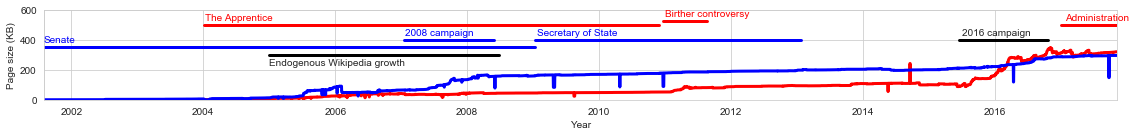

In [37]:
f,ax = plt.subplots(1,1,figsize=(16,2))

(daily_trump_revs.loc[:'2017-11-09','size']/1000).plot(lw=3,ax=ax,color='r',legend=False)
(daily_clinton_revs.loc[:'2017-11-09','size']/1000).plot(lw=3,ax=ax,color='b',legend=False)
ax.set_ylim((0,600))
ax.set_xlabel('Year')
ax.set_ylabel('Page size (KB)')

# Endogenous Wikipedia growth
ax.axhline(y=300,xmin=ts_frac(pd.Timestamp('2005-01-01')),xmax=ts_frac(pd.Timestamp('2008-07-01')),color='k',lw=3)
ax.annotate("Endogenous Wikipedia growth", xy=(ts_to_unix(pd.Timestamp('2005-01-01')), 250), xycoords="data", va="center", ha="left")

# Clinton as Senator
ax.axhline(y=350,xmin=ts_frac(all_revs_min_ts),xmax=ts_frac(pd.Timestamp('2009-01-21')),color='b',lw=3)
ax.annotate("Senate", xy=(ts_to_unix(all_revs_min_ts), 400), xycoords="data", va="center", ha="left", color='b')

# Clinton 2008 campaign
ax.axhline(y=400,xmin=ts_frac(pd.Timestamp('2007-01-20')),xmax=ts_frac(pd.Timestamp('2008-06-07')),color='b',lw=3)
ax.annotate("2008 campaign", xy=(ts_to_unix(pd.Timestamp('2007-01-20')), 450), va="center", ha="left", color='b')

# Clinton as SoS
ax.axhline(y=400,xmin=ts_frac(pd.Timestamp('2009-01-21')),xmax=ts_frac(pd.Timestamp('2013-02-01')),color='b',lw=3)
ax.annotate("Secretary of State", xy=(ts_to_unix(pd.Timestamp('2009-01-21')), 450), va="center", ha="left", color='b')

# Trump on Apprentice
ax.axhline(y=500,xmin=ts_frac(pd.Timestamp('2004-01-08')),xmax=ts_frac(pd.Timestamp('2010-12-09')),color='r',lw=3)
ax.annotate("The Apprentice", xy=(ts_to_unix(pd.Timestamp('2004-01-08')), 550), va="center", ha="left", color='r')

# Trump Birther controversy
ax.axhline(y=525,xmin=ts_frac(pd.Timestamp('2011-01-01')),xmax=ts_frac(pd.Timestamp('2011-09-01')),color='r',lw=3)
ax.annotate("Birther controversy", xy=(ts_to_unix(pd.Timestamp('2011-01-01')), 575), xycoords="data", va="center", ha="left", color='r')

# Presidential campaign
ax.axhline(y=400,xmin=ts_frac(pd.Timestamp('2015-07-01')),xmax=ts_frac(pd.Timestamp('2016-11-08')),color='k',lw=3)
ax.annotate("2016 campaign", xy=(ts_to_unix(pd.Timestamp('2015-07-01')), 450), xycoords="data", va="center", ha="left")

# Presidential administration
ax.axhline(y=500,xmin=ts_frac(pd.Timestamp('2017-01-20')),xmax=ts_frac(all_revs_max_ts),color='r',lw=3)
ax.annotate("Administration", xy=(ts_to_unix(pd.Timestamp('2017-01-20')), 550), va="center", ha="left", color='r')

plt.tight_layout()
plt.savefig('article_size_max.pdf')

In [38]:
trump_daily_size_max = daily_trump_revs.loc[:'2017-11-09']['size']
clinton_daily_size_max = daily_clinton_revs.loc[:'2017-11-09']['size']

F,p_F = stats.f_oneway(trump_daily_size_max.values,clinton_daily_size_max.values)
H,p_H = stats.kruskal(trump_daily_size_max.values,clinton_daily_size_max.values)

print("Trump mean size: {0:.3f}\nClinton mean size: {1:.3f}\nANOVA: {2:.2f} (p = {3:.3e})\n".format(trump_daily_size_max.mean(),clinton_daily_size_max.mean(),F,p_F))
print("Trump median size: {0:.3f}\nClinton median size: {1:.3f}\nKruskal-Wallis: {2:.2f} (p = {3:.3e})".format(trump_daily_size_max.median(),clinton_daily_size_max.median(),H,p_H))

Trump mean size: 91183.570
Clinton mean size: 134652.281
ANOVA: 649.11 (p = 3.611e-139)

Trump median size: 52032.000
Clinton median size: 167058.000
Kruskal-Wallis: 510.35 (p = 5.334e-113)


Text(0, 0.5, 'Page size (KB)')

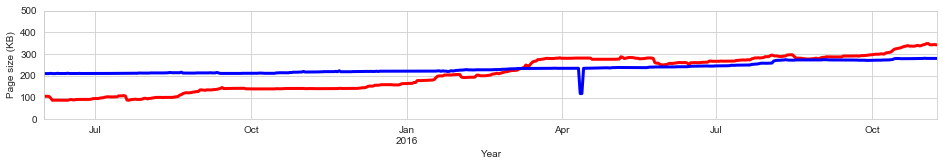

In [39]:
f,ax = plt.subplots(1,1,figsize=(16,2))
(daily_trump_revs.loc['2015-06-01':'2016-11-08']['size']/1000).plot(lw=3,ax=ax,color='r',legend=False)
(daily_clinton_revs.loc['2015-06-01':'2016-11-08']['size']/1000).plot(lw=3,ax=ax,color='b',legend=False)
ax.set_ylim((0,500))
ax.set_xlabel('Year')
ax.set_ylabel('Page size (KB)')

# ax.axvline(pd.Timestamp('2015-06-16'),color='k',zorder=-1) # Announcement
# ax.annotate('A',xy=(ts_to_unix(pd.Timestamp('2015-06-18')),450),va="center", ha="left", color='k', size=12)

# ax.axvline(pd.Timestamp('2016-03-09'),color='k',zorder=-1) # Super Tuesdays
# ax.annotate('B',xy=(ts_to_unix(pd.Timestamp('2016-03-11')),450),va="center", ha="left", color='k', size=12)

# ax.axvline(pd.Timestamp('2016-04-29'),color='k',zorder=-1) # Acela primary
# ax.annotate('C',xy=(ts_to_unix(pd.Timestamp('2016-05-01')),450),va="center", ha="left", color='k', size=12)

# ax.axvline(pd.Timestamp('2016-05-27'),color='k',zorder=-1) # Trump presumtive nominee
# ax.annotate('D',xy=(ts_to_unix(pd.Timestamp('2016-05-29')),450),va="center", ha="left", color='k', size=12)

# ax.axvline(pd.Timestamp('2016-06-08'),color='k',zorder=-1) # Clinton presumptive nominee
# ax.annotate('E',xy=(ts_to_unix(pd.Timestamp('2016-06-10')),450),va="center", ha="left", color='k', size=12)

# ax.axvline(pd.Timestamp('2016-07-21'),color='k',zorder=-1) # Republican National Convention
# ax.annotate('F',xy=(ts_to_unix(pd.Timestamp('2016-07-11')),450),va="center", ha="left", color='k', size=12)

# ax.axvline(pd.Timestamp('2016-07-28'),color='k',zorder=-1) # Democratic National convention
# ax.annotate('G',xy=(ts_to_unix(pd.Timestamp('2016-07-30')),450),va="center", ha="left", color='k', size=12)

# ax.axvline(pd.Timestamp('2016-10-07'),color='k',zorder=-1) # Access Hollywood tape
# ax.annotate('H',xy=(ts_to_unix(pd.Timestamp('2016-10-09')),450),va="center", ha="left", color='k', size=12)

# #ax.axvline(pd.Timestamp('2016-10-31'),color='k',zorder=-1) # User:Anthony22 edits
# #ax.annotate('I',xy=(ts_to_unix(pd.Timestamp('2016-11-02')),450),va="center", ha="left", color='k', size=12)

# ax.axvline(pd.Timestamp('2016-11-08'),color='k',zorder=-1) # Election
# ax.annotate('I',xy=(ts_to_unix(pd.Timestamp('2016-11-10')),450),va="center", ha="left", color='k', size=12)

# ax.axvline(pd.Timestamp('2017-01-20'),color='k',zorder=-1) # Inauguration
# ax.annotate('J',xy=(ts_to_unix(pd.Timestamp('2017-01-22')),450),va="center", ha="left", color='k', size=12)

# #ax.axvline(pd.Timestamp('2017-03-18'),color='k',zorder=-1) # User:Anthony22 edits
# #ax.annotate('L',xy=(ts_to_unix(pd.Timestamp('2017-03-20')),450),va="center", ha="left", color='k', size=12)

# #ax.axvline(pd.Timestamp('2017-04-18'),color='k',zorder=-1) # User:Anythingyouwant edits
# #ax.annotate('M',xy=(ts_to_unix(pd.Timestamp('2017-04-20')),450),va="center", ha="left", color='k', size=12)

In [40]:
print("Trump article before start of campaign: {0:.2f}".format(daily_trump_revs.loc['2015-05-30','size']))
print("Clinton article before start of campaign: {0:.2f}".format(daily_clinton_revs.loc['2016-05-30','size']))

Trump article before start of campaign: 106217.00
Clinton article before start of campaign: 241079.00


In [42]:
print("Trump article size at start of campaign: {0:,.2f}".format(daily_trump_revs.loc['2015-06-01','size']))
print("Trump article size at end of campaign: {0:,.2f}".format(daily_trump_revs.loc['2016-11-08','size']))
print("Clinton article size at end of campaign: {0:,.2f}".format(daily_clinton_revs.loc['2016-11-08','size']))
print("Ratio of ending to beginning size: {0:,.2f}".format(daily_trump_revs.loc['2016-11-08','size']/daily_trump_revs.loc['2015-06-01','size']))

Trump article size at start of campaign: 106,257.00
Trump article size at end of campaign: 342,705.00
Clinton article size at end of campaign: 280,403.00
Ratio of ending to beginning size: 3.23


In [45]:
trump_daily_size_campaign = daily_trump_revs.loc['2015-06-01':'2016-11-07']['size']
clinton_daily_size_campaign = daily_clinton_revs.loc['2015-06-01':'2016-11-07']['size']

F,p_F = stats.f_oneway(trump_daily_size_campaign.values,clinton_daily_size_campaign.values)
H,p_H = stats.kruskal(trump_daily_size_campaign.values,clinton_daily_size_campaign.values)

print("Trump mean size: {0:,.1f}\nClinton mean size: {1:,.1f}\nANOVA: {2:.2f} (p = {3:.3e})\n".format(trump_daily_size_campaign.mean(),clinton_daily_size_campaign.mean(),F,p_F))
print("Trump median size: {0:,.1f}\nClinton median size: {1:,.1f}\nKruskal-Wallis: {2:.2f} (p = {3:.3e})".format(trump_daily_size_campaign.median(),clinton_daily_size_campaign.median(),H,p_H))

Trump mean size: 208,779.6
Clinton mean size: 234,294.1
ANOVA: 52.29 (p = 9.224e-13)

Trump median size: 206,703.8
Clinton median size: 228,256.0
Kruskal-Wallis: 8.23 (p = 4.111e-03)


When did Trump's article size surpass Clinton's?

In [46]:
daily_trump_revs.loc[idx['2015-01-01':'2017-11-09'],'size'][daily_trump_revs.loc[idx['2015-01-01':'2017-11-09'],'size'] > daily_clinton_revs.loc[idx['2015-01-01':'2017-11-09'],'size']].idxmin()

Timestamp('2016-03-09 00:00:00')

### Pageviews

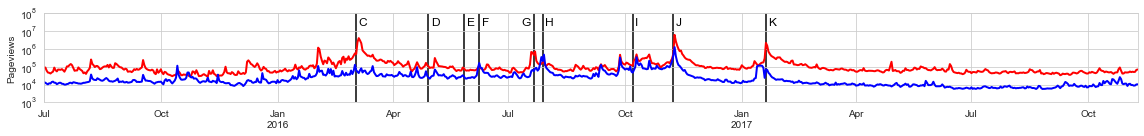

In [53]:
trump_pv_df = cleaned_trump_pv_df.loc['Donald Trump',('all-agents','all-access')]
trump_pv_df = trump_pv_df.reindex(pd.date_range(trump_pv_df.index.min(),trump_pv_df.index.max()),fill_value=0)

clinton_pv_df = cleaned_clinton_pv_df.loc['Hillary Clinton',('all-agents','all-access')]
clinton_pv_df = clinton_pv_df.reindex(pd.date_range(clinton_pv_df.index.min(),clinton_pv_df.index.max()),fill_value=0)

f,ax = plt.subplots(1,1,figsize=(16,2))

trump_pv_df.loc['2015-07-01':'2017-11-09'].plot(lw=2,ax=ax,color=['r'],legend=False)
clinton_pv_df.loc['2015-07-01':'2017-11-09'].plot(lw=2,ax=ax,color=['b'],legend=False)
ax.set_ylim((1e3,1e8))
ax.set_yscale('log')
ax.set_ylabel('Pageviews')
ax.set_yticks([1e3,1e4,1e5,1e6,1e7,1e8])

#ax.axvline(pd.Timestamp('2015-06-16'),color='k',zorder=-1) # Announcement
#ax.annotate('B',xy=(ts_to_unix(pd.Timestamp('2015-06-18')),175),va="center", ha="left", color='k', size=12)

_height = 3e7

ax.axvline(pd.Timestamp('2016-03-03'),color='k',zorder=-1) # Super Tuesdays
ax.annotate('C',xy=(ts_to_unix(pd.Timestamp('2016-03-05')),_height),va="center", ha="left", color='k', size=12)

ax.axvline(pd.Timestamp('2016-04-29'),color='k',zorder=-1) # Acela primary
ax.annotate('D',xy=(ts_to_unix(pd.Timestamp('2016-05-01')),_height),va="center", ha="left", color='k', size=12)

ax.axvline(pd.Timestamp('2016-05-27'),color='k',zorder=-1) # Trump presumtive nominee
ax.annotate('E',xy=(ts_to_unix(pd.Timestamp('2016-05-29')),_height),va="center", ha="left", color='k', size=12)

ax.axvline(pd.Timestamp('2016-06-08'),color='k',zorder=-1) # Clinton presumptive nominee
ax.annotate('F',xy=(ts_to_unix(pd.Timestamp('2016-06-10')),_height),va="center", ha="left", color='k', size=12)

ax.axvline(pd.Timestamp('2016-07-21'),color='k',zorder=-1) # Republican National Convention
ax.annotate('G',xy=(ts_to_unix(pd.Timestamp('2016-07-11')),_height),va="center", ha="left", color='k', size=12)

ax.axvline(pd.Timestamp('2016-07-28'),color='k',zorder=-1) # Democratic National convention
ax.annotate('H',xy=(ts_to_unix(pd.Timestamp('2016-07-30')),_height),va="center", ha="left", color='k', size=12)

ax.axvline(pd.Timestamp('2016-10-07'),color='k',zorder=-1) # Access Hollywood tape
ax.annotate('I',xy=(ts_to_unix(pd.Timestamp('2016-10-09')),_height),va="center", ha="left", color='k', size=12)

ax.axvline(pd.Timestamp('2016-11-08'),color='k',zorder=-1) # Election
ax.annotate('J',xy=(ts_to_unix(pd.Timestamp('2016-11-10')),_height),va="center", ha="left", color='k', size=12)

ax.axvline(pd.Timestamp('2017-01-20'),color='k',zorder=-1) # Inauguration
ax.annotate('K',xy=(ts_to_unix(pd.Timestamp('2017-01-22')),_height),va="center", ha="left", color='k', size=12)

#ax.axvspan(pd.Timestamp('2016-03-01'),pd.Timestamp('2016-03-15'),color='r',zorder=-1,alpha=.25) # Super Tuesdays
#ax.axvline(pd.Timestamp('2016-07-21'),color='r',zorder=-1) # National Convention
#ax.axvline(pd.Timestamp('2016-10-07'),color='r',zorder=-1) # Access Hollywood tape
#ax.axvline(pd.Timestamp('2016-11-09'),color='r',zorder=-1) # Election
#ax.axvline(pd.Timestamp('2017-01-20'),color='r',zorder=-1) # Inauguration
#ax.axvline(pd.Timestamp('2017-05-16'),color='r',zorder=-1) # Comey dismissal

plt.tight_layout()
plt.savefig('article_pageviews_campaign.pdf')

In [54]:
trump_daily_pv_campaign = trump_pv_df.loc['2015-06-01':'2016-11-09']
clinton_daily_pv_campaign = clinton_pv_df.loc['2015-06-01':'2016-11-09']

F,p_F = stats.f_oneway(trump_daily_pv_campaign.values,clinton_daily_pv_campaign.values)
H,p_H = stats.kruskal(trump_daily_pv_campaign.values,clinton_daily_pv_campaign.values)

print("Clinton mean page views: {1:,.1f}\nTrump mean page views: {0:,.1f}\nANOVA: {2:.2f} (p = {3:.3e})\n".format(trump_daily_pv_campaign.mean(),clinton_daily_pv_campaign.mean(),F,p_F))
print("Clinton median page views: {1:,.1f}\nTrump median page views: {0:,.1f}\nKruskal-Wallis: {2:.2f} (p = {3:.3e})".format(trump_daily_pv_campaign.median(),clinton_daily_pv_campaign.median(),H,p_H))

Clinton mean page views: 41,787.3
Trump mean page views: 159,283.1
ANOVA: 42.73 (p = 1.005e-10)

Clinton median page views: 27,301.5
Trump median page views: 83,086.0
Kruskal-Wallis: 460.61 (p = 3.543e-102)


What days did Clinton's page views surpass Trump's?

In [55]:
clinton_daily_pv_campaign[clinton_daily_pv_campaign > trump_daily_pv_campaign]

2015-10-14    114782.0
2015-10-22     47717.0
2015-10-23     47703.0
2015-11-15     36096.0
2016-06-08    164013.0
2016-06-09     88033.0
2016-06-10     85796.0
2016-07-26    146130.0
2016-07-27    353079.0
2016-07-28    212981.0
2016-07-29    482980.0
2016-07-30    125481.0
Name: (all-agents, all-access), dtype: float64

In [56]:
clinton_daily_pv_campaign.sum()

20810054.0

In [57]:
print("Clinton received {0:,.0f} page views over the course of the campaign".format(clinton_pv_df.loc['2015-07-01':'2016-11-08'].sum()))
print("Trump received {0:,.0f} page views over the course of the campaign".format(trump_pv_df.loc['2015-07-01':'2016-11-08'].sum()))

Clinton received 19,535,002 page views over the course of the campaign
Trump received 73,116,431 page views over the course of the campaign


In [58]:
trump_pv_df.loc['2015-07-01':'2016-11-08'].sum()/clinton_pv_df.loc['2015-07-01':'2016-11-08'].sum()

3.7428422582193748

### Correlations between 538 and activity?

In [65]:
campaign_activity_df[_fte_cols].resample('W').sum().diff()

,Trump 538,Clinton 538
2016-06-12,NaN,NaN
2016-06-19,57.611446,241.511489
2016-06-26,-9.101791,9.111760
2016-07-03,28.725970,-28.740924
2016-07-10,-2.377631,2.392585
2016-07-17,79.548457,-79.448766
2016-07-24,51.694784,-51.769552
2016-07-31,91.351875,-91.401721
2016-08-07,-285.221021,285.230990
2016-08-14,-10.995921,11.060720


In [69]:
campaign_activity_df = pd.DataFrame({'Trump PV':trump_pv_df.loc['2016-06-09':'2016-11-08'].cumsum(),
                        'Clinton PV':clinton_pv_df.loc['2016-06-09':'2016-11-08'].cumsum(),
                        'Trump Size':daily_trump_revs.loc['2016-06-09':'2016-11-08']['size'],
                        'Clinton Size':daily_clinton_revs.loc['2016-06-09':'2016-11-08']['size'],
                        'Trump Revs':daily_trump_revs.loc['2016-06-09':'2016-11-08']['sha1'].cumsum(),
                        'Clinton Revs':daily_clinton_revs.loc['2016-06-09':'2016-11-08']['sha1'].cumsum(),
                        'Trump 538':fte_df.loc[:,'Trump 538'],
                        'Clinton 538':fte_df.loc[:,'Clinton 538']})

for _col in campaign_activity_df.columns:
    campaign_activity_df['{0} lag {1}'.format(_col,-1)] = campaign_activity_df[_col].shift(-1)

_fte_cols = ['Trump 538','Clinton 538']
_df1 = campaign_activity_df[_fte_cols].resample('W').mean().diff()
_df2 = campaign_activity_df[[_col for _col in campaign_activity_df.columns if _col not in _fte_cols]].resample('W').mean().pct_change()
weekly_campaign_activity_df = pd.concat([_df1,_df2],axis=1)

In [70]:
weekly_corr_df = weekly_campaign_activity_df.corr()
#weekly_corr_df = weekly_corr_df.mask(np.triu(np.ones(weekly_corr_df.shape),0).astype(bool))
weekly_corr_df = weekly_corr_df.stack().reset_index().sort_values('level_1')
weekly_corr_df[weekly_corr_df['level_1'] == 'Clinton 538 lag -1'].sort_values(0)

,level_0,level_1,0
15,Trump 538,Clinton 538 lag -1,-0.973190
239,Trump 538 lag -1,Clinton 538 lag -1,-0.876883
143,Trump PV lag -1,Clinton 538 lag -1,-0.073009
47,Trump PV,Clinton 538 lag -1,-0.055926
111,Trump Revs,Clinton 538 lag -1,-0.003388
207,Trump Revs lag -1,Clinton 538 lag -1,0.000729
159,Clinton PV lag -1,Clinton 538 lag -1,0.026134
223,Clinton Revs lag -1,Clinton 538 lag -1,0.032878
127,Clinton Revs,Clinton 538 lag -1,0.040115
63,Clinton PV,Clinton 538 lag -1,0.070337


In [71]:
## corr_df = campaign_activity_df.corr()#.stack().reset_index().sort_values(0,ascending=False)
corr_df = campaign_activity_df.corr()
corr_df = corr_df.mask(np.triu(np.ones(corr_df.shape),0).astype(bool))
melted_corr_df = corr_df.stack().reset_index()
melted_corr_df.columns = ['Var 1','Var 2','Corr']
melted_corr_df['Abs Corr'] = melted_corr_df['Corr'].apply(np.abs)

_c1 = melted_corr_df['Var 1'].str.split(' ').str.get(1) != melted_corr_df['Var 2'].str.split(' ').str.get(1)
_c2 = melted_corr_df['Var 1'].str.split(' ').str.get(-2) != melted_corr_df['Var 2'].str.split(' ').str.get(-2)
_c3 = melted_corr_df['Var 1'].str.contains('538') | melted_corr_df['Var 2'].str.contains('538')
_c4 = melted_corr_df['Var 1'].str.contains('538 lag -1') | melted_corr_df['Var 2'].str.contains('538 lag -1')
melted_corr_df[(_c1 & _c2) & (_c3 | _c4)].sort_values('Abs Corr',ascending=False)#.loc[::2,:]

,Var 1,Var 2,Corr,Abs Corr
62,Clinton Size lag -1,Clinton 538,0.069660,0.069660
61,Clinton Size lag -1,Trump 538,-0.069047,0.069047
18,Trump 538,Clinton Size,-0.058358,0.058358
108,Clinton 538 lag -1,Clinton Size,0.056977,0.056977
94,Trump 538 lag -1,Clinton Size,-0.056353,0.056353
107,Clinton 538 lag -1,Trump Size,0.042074,0.042074
93,Trump 538 lag -1,Trump Size,-0.041111,0.041111
52,Trump Size lag -1,Clinton 538,0.040111,0.040111
51,Trump Size lag -1,Trump 538,-0.039140,0.039140
106,Clinton 538 lag -1,Clinton PV,0.035112,0.035112


### Page protections

In [545]:
clinton_redirect_mapping = {r:article for article,redirects in clinton_redirect_members.items() for r in redirects}
trump_redirect_mapping = {r:article for article,redirects in trump_redirect_members.items() for r in redirects}

In [585]:
trump_article_le_df['action'].value_counts()

approve-a     905
patrol        531
approve       135
revision       30
reviewed       27
modify         17
delete         15
autopatrol     15
unapprove      11
protect         7
move            3
unprotect       2
move_prot       2
approve-ia      1
config          1
reset           1
restore         1
Name: action, dtype: int64

In [586]:
trump_article_le_df['type'].value_counts()

review                 1052
patrol                  546
delete                   44
protect                  28
pagetriage-curation      28
move                      3
stable                    2
pagetriage-deletion       1
Name: type, dtype: int64

In [1129]:
trump_article_le_df[trump_article_le_df['action'] == 'protect'].loc[10769,:]

action                                         protect
comment          Persistent [[WP:Vandalism|vandalism]]
date                               2016-02-01 00:00:00
logid                                      7.22434e+07
logpage                                     3.2553e+06
ns                                                   0
page                                      Donald trump
pageid                                      3.2553e+06
tags                                                []
timestamp                          2016-02-01 23:55:51
title                                     Donald trump
type                                           protect
user                                           Gilliam
userid                                          506179
redirect_page                             Donald Trump
Name: 10769, dtype: object

### Redirects

In [72]:
with open('clinton_category_members_redirects.json','r') as f:
    clinton_redirect_members = json.load(f)
    
with open('trump_category_members_redirects.json','r') as f:
    trump_redirect_members = json.load(f)
    
print("There are {0:,} redirects resolving to \"Hillary Clinton\"".format(len(clinton_redirect_members['Hillary Clinton'])))
print("There are {0:,} redirects resolving to \"Donald Trump\"".format(len(trump_redirect_members['Donald Trump'])))

There are 78 redirects resolving to "Hillary Clinton"
There are 67 redirects resolving to "Donald Trump"


# Related articles

In [73]:
all_clinton_article_creations = all_clinton_rev_df.groupby('page').agg({'date':np.min})['date']
all_trump_article_creations = all_trump_rev_df.groupby('page').agg({'date':np.min})['date']

articles_for_both_candidates = list(set(all_clinton_article_creations.index) & set(all_trump_article_creations.index))
print("There are {0:} articles related to both candidates".format(len(articles_for_both_candidates)))

all_clinton_article_creations = all_clinton_article_creations.loc[set(all_clinton_article_creations.index) - set(articles_for_both_candidates)]
all_trump_article_creations = all_trump_article_creations.loc[set(all_trump_article_creations.index) - set(articles_for_both_candidates)]

print("{0:,} Clinton-related articles underneath the Clinton category".format(len(all_clinton_article_creations)))
print("{0:,} Trump-related articles underneath the Trump category".format(len(all_trump_article_creations)))

There are 16 articles related to both candidates
1,320 Clinton-related articles underneath the Clinton category
933 Trump-related articles underneath the Trump category


In [74]:
new_articles_clinton = all_clinton_article_creations[all_clinton_article_creations > pd.Timestamp('2015-01-01')]
new_articles_trump = all_trump_article_creations[all_trump_article_creations > pd.Timestamp('2015-01-01')]

print("{0:,} Clinton-related articles were created after January 1, 2015".format(len(new_articles_clinton)))
print("{0:,} Trump-related articles were created after January 1, 2015".format(len(new_articles_trump)))

clinton_creation_dates = new_articles_clinton.reset_index().groupby('date').apply(len)
trump_creation_dates = new_articles_trump.reset_index().groupby('date').apply(len)

#clinton_creation_dates = all_clinton_article_creations.reset_index().groupby('date').apply(len)
#trump_creation_dates = all_trump_article_creations.reset_index().groupby('date').apply(len)

84 Clinton-related articles were created after January 1, 2015
692 Trump-related articles were created after January 1, 2015


Generate the raw data for new articles, revisions, editors, and page views.

In [125]:
_clinton_all_subdf = all_clinton_rev_df[(all_clinton_rev_df['date'] > pd.Timestamp('2015-01-01')) & (all_clinton_rev_df['page'] != 'Hillary Clinton') & (all_clinton_rev_df['page'].isin(all_clinton_article_creations.index))]
_clinton_new_subdf = _clinton_all_subdf[_clinton_all_subdf['page'].isin(new_articles_clinton.index)]

_trump_all_subdf = all_trump_rev_df[(all_trump_rev_df['date'] > pd.Timestamp('2015-01-01')) & (all_trump_rev_df['page'] != 'Donald Trump') & (all_trump_rev_df['page'].isin(all_trump_article_creations.index))]
_trump_new_subdf = _trump_all_subdf[_trump_all_subdf['page'].isin(new_articles_trump.index)]

_clinton_all_articles = _clinton_all_subdf['page'].unique()
_clinton_new_articles = _clinton_new_subdf['page'].unique()
_trump_all_articles = _trump_all_subdf['page'].unique()
_trump_new_articles = _trump_new_subdf['page'].unique()

_agg = {'revid':pd.Series.nunique,'size':np.median,'size_diff':np.sum}

_clinton_all_agg_df = _clinton_all_subdf.groupby(['date']).agg(_agg)
_trump_all_agg_df = _trump_all_subdf.groupby(['date']).agg(_agg) 

_clinton_new_agg_df = _clinton_new_subdf.groupby(['date']).agg(_agg)
_trump_new_agg_df = _trump_new_subdf.groupby(['date']).agg(_agg) 

def list_set(x):
    return list(set(x))

# Editors
#_clinton_all_editors = _clinton_all_subdf.groupby(['page','date'])['user'].apply(list_set).sum(level=1).cumsum().apply(list_set).apply(len).reindex(pd.date_range('2015-01-01','2017-11-09')).fillna(method='ffill').fillna(0)
# _trump_all_editors = _trump_all_subdf.groupby(['page','date'])['user'].apply(list_set).sum(level=1).cumsum().apply(list_set).apply(len).reindex(pd.date_range('2015-01-01','2017-11-09')).fillna(method='ffill').fillna(0)

_clinton_all_editors = _clinton_all_subdf.groupby(['date'])['user'].apply(list_set).cumsum().apply(len).reindex(pd.date_range('2015-01-01','2017-11-09')).fillna(method='ffill').fillna(0)
_trump_all_editors = _trump_all_subdf.groupby(['date'])['user'].apply(list_set).cumsum().apply(len).reindex(pd.date_range('2015-01-01','2017-11-09')).fillna(method='ffill').fillna(0)

#_clinton_new_editors = _clinton_new_subdf.groupby(['page','date'])['user'].apply(list_set).sum(level=1).cumsum().apply(list_set).apply(len).reindex(pd.date_range('2015-01-01','2017-11-09')).fillna(method='ffill').fillna(0)
#_trump_new_editors = _trump_new_subdf.groupby(['page','date'])['user'].apply(list_set).sum(level=1).cumsum().apply(list_set).apply(len).reindex(pd.date_range('2015-01-01','2017-11-09')).fillna(method='ffill').fillna(0)
_clinton_new_editors = _clinton_new_subdf.groupby(['date'])['user'].apply(list_set).cumsum().apply(len).reindex(pd.date_range('2015-01-01','2017-11-09')).fillna(method='ffill').fillna(0)
_trump_new_editors = _trump_new_subdf.groupby(['date'])['user'].apply(list_set).cumsum().apply(len).reindex(pd.date_range('2015-01-01','2017-11-09')).fillna(method='ffill').fillna(0)

# Page views
_clinton_all_pvs = all_clinton_pv_df[('all-agents','all-access')].loc[_clinton_all_articles].sum(level=1)
_clinton_new_pvs = all_clinton_pv_df[('all-agents','all-access')].loc[_clinton_new_articles].sum(level=1)

_trump_all_pvs = all_trump_pv_df[('all-agents','all-access')].loc[_trump_all_articles].sum(level=1)
_trump_new_pvs = all_trump_pv_df[('all-agents','all-access')].loc[_trump_new_articles].sum(level=1)

Format the page view data so it's compatible with the other plots.

In [139]:
_date_range = pd.date_range('2015-01-01','2017-11-09')

_clinton_all_pvs = all_clinton_pv_df[('all-agents','all-access')].loc[_clinton_all_articles].sum(level=1)
_clinton_all_pvs.index = pd.to_datetime(_clinton_all_pvs.index)
_clinton_all_pvs = _clinton_all_pvs.reindex(_date_range).fillna(0)

_clinton_new_pvs = all_clinton_pv_df[('all-agents','all-access')].loc[_clinton_new_articles].sum(level=1)
_clinton_new_pvs.index = pd.to_datetime(_clinton_new_pvs.index)
_clinton_new_pvs = _clinton_new_pvs.reindex(_date_range).fillna(0)

_trump_all_pvs = all_trump_pv_df[('all-agents','all-access')].loc[_trump_all_articles].sum(level=1)
_trump_all_pvs.index = pd.to_datetime(_trump_all_pvs.index)
_trump_all_pvs = _trump_all_pvs.reindex(_date_range).fillna(0)

_trump_new_pvs = all_trump_pv_df[('all-agents','all-access')].loc[_trump_new_articles].sum(level=1)
_trump_new_pvs.index = pd.to_datetime(_trump_new_pvs.index)
_trump_new_pvs = _trump_new_pvs.reindex(_date_range).fillna(0)

Create the DataFrames that will be used for plotting.

In [150]:
both_new_article_creations = pd.DataFrame({'Clinton':clinton_creation_dates,
                                           'Trump':trump_creation_dates})
both_new_article_creations = both_new_article_creations.reindex(_date_range).fillna(0)

# Revisions
both_all_article_revisions = pd.DataFrame({'Clinton':_clinton_all_agg_df['revid'],
                                           'Trump':_trump_all_agg_df['revid']})
both_all_article_revisions = both_all_article_revisions.reindex(_date_range).fillna(0)

both_new_article_revisions = pd.DataFrame({'Clinton':_clinton_new_agg_df['revid'],
                                           'Trump':_trump_new_agg_df['revid']})
both_new_article_revisions = both_new_article_revisions.reindex(_date_range).fillna(0)

# Editors
both_all_article_editors = pd.DataFrame({'Clinton':_clinton_all_editors,
                                         'Trump':_trump_all_editors})
both_new_article_editors = pd.DataFrame({'Clinton':_clinton_new_editors,
                                         'Trump':_trump_new_editors})

# Size
both_all_article_size = pd.DataFrame({'Clinton':_clinton_all_agg_df['size_diff'].cumsum(),
                                      'Trump':_trump_all_agg_df['size_diff'].cumsum()})
both_all_article_size = both_all_article_size.reindex(_date_range).fillna(method='ffill')
both_new_article_size = pd.DataFrame({'Clinton':_clinton_new_agg_df['size_diff'].cumsum(),
                                      'Trump':_trump_new_agg_df['size_diff'].cumsum()})
both_new_article_size = both_new_article_size.reindex(_date_range).fillna(method='ffill')

# Pageviews
both_all_article_pvs = pd.DataFrame({'Clinton':_clinton_all_pvs,
                                     'Trump':_trump_all_pvs})
both_all_article_pvs = both_all_article_pvs.reindex(_date_range).fillna(0)
both_new_article_pvs = pd.DataFrame({'Clinton':_clinton_new_pvs,
                                     'Trump':_trump_new_pvs})
both_new_article_pvs = both_new_article_pvs.reindex(_date_range).fillna(0)

Make the plots.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\scale.py:489: RuntimeWarning: invalid value encountered in sign
  sign = np.sign(a)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\ma\core.py:2146: RuntimeWarning: invalid value encountered in greater_equal
  condition = (xf >= v1) & (xf <= v2)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\ma\core.py:2146: RuntimeWarning: invalid value encountered in less_equal
  condition = (xf >= v1) & (xf <= v2)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\scale.py:489: RuntimeWarning: invalid value encountered in sign
  sign = np.sign(a)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\ma\core.py:2146: RuntimeWarning: invalid value encountered in greater_equal
  condition = (xf >= v1) & (xf <= v2)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\ma\core.py:2146: RuntimeWarning: invalid value encountered in less_equal
  condition = (xf >= v1) & (xf <= v2)


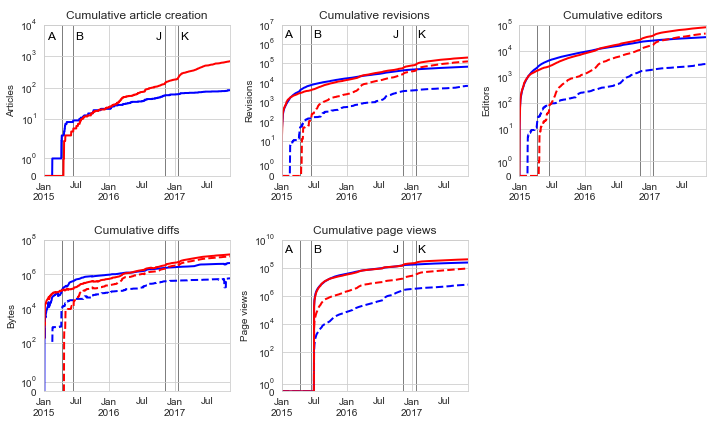

In [155]:
f,axs = plt.subplots(2,3,figsize=(10,6))

both_new_article_creations.cumsum().plot(color=['b','r'],lw=2,legend=False,ax=axs[0][0])
axs[0][0].set_ylim((0,1e4))
axs[0][0].set_yscale('symlog')
axs[0][0].set_ylabel('Articles')
axs[0][0].set_title('Cumulative article creation')

both_all_article_revisions.cumsum().plot(color=['b','r'],lw=2,legend=False,ax=axs[0][1])
both_new_article_revisions.cumsum().plot(color=['b','r'],style=['--','--'],lw=2,legend=False,ax=axs[0][1])
axs[0][1].set_ylim((0,1e7))
axs[0][1].set_yscale('symlog')
axs[0][1].set_ylabel('Revisions')
axs[0][1].set_title('Cumulative revisions')

both_all_article_editors.plot(color=['b','r'],lw=2,legend=False,ax=axs[0][2])
both_new_article_editors.plot(color=['b','r'],style=['--','--'],lw=2,legend=False,ax=axs[0][2])
axs[0][2].set_ylim((0,1e5))
axs[0][2].set_yticks([0,1e0,1e1,1e2,1e3,1e4,1e5])
axs[0][2].set_yscale('symlog')
axs[0][2].set_ylabel('Editors')
axs[0][2].set_title('Cumulative editors')

both_all_article_size.plot(color=['b','r'],lw=2,legend=False,ax=axs[1][0])
both_new_article_size.plot(color=['b','r'],style=['--','--'],lw=2,legend=False,ax=axs[1][0])
axs[1][0].set_ylim((0,1e8))
axs[1][0].set_yscale('symlog')
axs[1][0].set_ylabel('Bytes')
axs[1][0].set_yticks([0,1e0,1e2,1e4,1e6,1e8])
axs[1][0].set_title('Cumulative diffs')

both_all_article_pvs.cumsum().plot(color=['b','r'],lw=2,legend=False,ax=axs[1][1])
both_new_article_pvs.cumsum().plot(color=['b','r'],style=['--','--'],lw=2,legend=False,ax=axs[1][1])
axs[1][1].set_ylim((0,1e10))
axs[1][1].set_yscale('symlog')
axs[1][1].set_ylabel('Page views')
axs[1][1].set_yticks([0,1e0,1e2,1e4,1e6,1e8,1e10])
axs[1][1].set_title('Cumulative page views')

#axs[3].axvline(pd.Timestamp('2015-07-01'),color='k',zorder=10, lw=1)
#axs[3].annotate('*',xy=(pd.Timestamp('2015-07-15'),1e9),va="center", ha="left", color='k', size=12)

for _ax,_height in zip(axs.flatten(),[4e3,3e6,3e5,2e9,2e9]):
    _ax.axvline(pd.Timestamp('2015-04-12'),color='k',zorder=-1, lw=.5) # Clinton Announcement
    _ax.annotate('A',xy=(pd.Timestamp('2015-01-15'),_height),va="center", ha="left", color='k', size=12)
    
    _ax.axvline(pd.Timestamp('2015-06-13'),color='k',zorder=-1, lw=.5) # Trump Announcement
    _ax.annotate('B',xy=(pd.Timestamp('2015-06-23'),_height),va="center", ha="left", color='k', size=12)

    _ax.axvline(pd.Timestamp('2016-11-08'),color='k',zorder=-1, lw=.5) # Election
    _ax.annotate('J',xy=(pd.Timestamp('2016-09-15'),_height),va="center", ha="left", color='k', size=12)
    
    _ax.axvline(pd.Timestamp('2017-01-20'),color='k',zorder=-1, lw=.5) # Inauguration
    _ax.annotate('K',xy=(pd.Timestamp('2017-01-30'),_height),va="center", ha="left", color='k', size=12)

f.delaxes(axs[1][2])    

plt.tight_layout()
plt.savefig('child_article_dynamics_wide.pdf',bbox_inches='tight')

### Revisions
Generate the stats reported in the manuscript.

In [49]:
_clinton_all_revs_for_stats =  _clinton_all_agg_df['revid'].unstack(0).reindex(_date_range).fillna(0)
_trump_all_revs_for_stats = _trump_all_agg_df['revid'].unstack(0).reindex(_date_range).fillna(0)

_clinton_new_revs_for_stats =  _clinton_new_agg_df['revid'].unstack(0).reindex(_date_range).fillna(0)
_trump_new_revs_for_stats = _trump_new_agg_df['revid'].unstack(0).reindex(_date_range).fillna(0)

# January to Trump announcement revisions
_clinton_precampaign_all_revs = _clinton_all_revs_for_stats.loc['2015-01-01':'2015-06-12'].sum()
_trump_precampaign_all_revs = _trump_all_revs_for_stats.loc['2015-01-01':'2015-06-12'].sum()
_H_precampaign_all_revs, _p_precampaign_all_revs = stats.kruskal(_clinton_precampaign_all_revs,_trump_precampaign_all_revs)

_clinton_precampaign_new_revs = _clinton_new_revs_for_stats.loc['2015-01-01':'2015-06-12'].sum()
_trump_precampaign_new_revs = _trump_new_revs_for_stats.loc['2015-01-01':'2015-06-12'].sum()
_H_precampaign_new_revs, _p_precampaign_new_revs = stats.kruskal(_clinton_precampaign_new_revs,_trump_precampaign_new_revs)

print("Clinton's all related articles had a mean of {0:,.1f} pre-campaign revisions\nTrump's all related articles had a mean of {1:,.1f} pre-campaign revisions\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_precampaign_all_revs.mean(),_trump_precampaign_all_revs.mean(),_H_precampaign_all_revs,_p_precampaign_all_revs))
print("Clinton's new related articles had a mean of {0:,.1f} pre-campaign revisions\nTrump's new related articles had a mean of {1:,.1f} pre-campaign revisions\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_precampaign_new_revs.mean(),_trump_precampaign_new_revs.mean(),_H_precampaign_new_revs,_p_precampaign_new_revs))
print("-------------\n")

# Campaign revisions
_clinton_campaign_all_revs = _clinton_all_revs_for_stats.loc['2015-06-13':'2016-11-07'].sum()
_trump_campaign_all_revs = _trump_all_revs_for_stats.loc['2015-06-13':'2016-11-07'].sum()
_H_campaign_all_revs, _p_campaign_all_revs = stats.kruskal(_clinton_campaign_all_revs,_trump_campaign_all_revs)

_clinton_campaign_new_revs = _clinton_new_revs_for_stats.loc['2015-06-13':'2016-11-07'].sum()
_trump_campaign_new_revs = _trump_new_revs_for_stats.loc['2015-06-13':'2016-11-07'].sum()
_H_campaign_new_revs, _p_campaign_new_revs = stats.kruskal(_clinton_campaign_new_revs,_trump_campaign_new_revs)

print("Clinton's all related articles had a mean of {0:,.1f} campaign revisions\nTrump's all related articles had a mean of {1:,.1f} campaign revisions\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_campaign_all_revs.mean(),_trump_campaign_all_revs.mean(),_H_campaign_all_revs,_p_campaign_all_revs))
print("Clinton's new related articles had a mean of {0:,.1f} campaign revisions\nTrump's new related articles had a mean of {1:,.1f} campaign revisions\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_campaign_new_revs.mean(),_trump_campaign_new_revs.mean(),_H_campaign_new_revs,_p_campaign_new_revs))
print("-------------\n")

# Post-election revisions
_clinton_postcampaign_all_revs = _clinton_all_revs_for_stats.loc['2016-11-08':'2017-11-09'].sum()
_trump_postcampaign_all_revs = _trump_all_revs_for_stats.loc['2016-11-08':'2017-11-09'].sum()
_H_postcampaign_all_revs, _p_postcampaign_all_revs = stats.kruskal(_clinton_postcampaign_all_revs,_trump_postcampaign_all_revs)

_clinton_postcampaign_new_revs = _clinton_new_revs_for_stats.loc['2016-11-08':'2017-11-09'].sum()
_trump_postcampaign_new_revs = _trump_new_revs_for_stats.loc['2016-11-08':'2017-11-09'].sum()
_H_postcampaign_new_revs, _p_postcampaign_new_revs = stats.kruskal(_clinton_postcampaign_new_revs,_trump_postcampaign_new_revs)

print("Clinton's all related articles had a mean of {0:,.1f} post-campaign revisions\nTrump's all related articles had a mean of {1:,.1f} post-campaign revisions\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_postcampaign_all_revs.mean(),_trump_postcampaign_all_revs.mean(),_H_postcampaign_all_revs,_p_postcampaign_all_revs))
print("Clinton's new related articles had a mean of {0:,.1f} post-campaign revisions\nTrump's new related articles had a mean of {1:,.1f} post-campaign revisions\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_postcampaign_new_revs.mean(),_trump_postcampaign_new_revs.mean(),_H_postcampaign_new_revs,_p_postcampaign_new_revs))

Clinton's all related articles had a mean of 5.9 pre-campaign revisions
Trump's all related articles had a mean of 4.4 pre-campaign revisions
H = 410.9 (p = 2.351e-91)

Clinton's new related articles had a mean of 1.7 pre-campaign revisions
Trump's new related articles had a mean of 0.2 pre-campaign revisions
H = 39.2 (p = 3.827e-10)

-------------

Clinton's all related articles had a mean of 28.2 campaign revisions
Trump's all related articles had a mean of 55.0 campaign revisions
H = 267.0 (p = 5.208e-60)

Clinton's new related articles had a mean of 41.1 campaign revisions
Trump's new related articles had a mean of 38.2 campaign revisions
H = 82.6 (p = 1.013e-19)

-------------

Clinton's all related articles had a mean of 19.2 post-campaign revisions
Trump's all related articles had a mean of 154.6 post-campaign revisions
H = 351.5 (p = 1.960e-78)

Clinton's new related articles had a mean of 38.8 post-campaign revisions
Trump's new related articles had a mean of 144.1 post-campai

Total revision by election.

In [50]:
both_all_article_revisions.cumsum().loc['2016-11-07']

Clinton    43010.0
Trump      55232.0
Name: 2016-11-07 00:00:00, dtype: float64

In [51]:
both_new_article_revisions.cumsum().loc['2016-11-07']

Clinton     3602.0
Trump      26557.0
Name: 2016-11-07 00:00:00, dtype: float64

Top articles from the pre-campaign phase.

In [52]:
_clinton_precampaign_all_revs.sort_values(ascending=False).head()

page
Hillary Clinton presidential campaign, 2016    518.0
Ash Carter                                     207.0
NATO bombing of Yugoslavia                     174.0
Broad City                                     142.0
Sheryl Sandberg                                123.0
dtype: float64

In [53]:
_clinton_precampaign_new_revs.sort_values(ascending=False).head()

page
Clinton Cash                    57.0
Executive Order 13175           26.0
Maryscott (Scotty) Greenwood    17.0
Clinton: The Musical            15.0
Ann O'Leary                     10.0
dtype: float64

In [54]:
_trump_precampaign_all_revs.sort_values(ascending=False).head()

page
Miss Universe                      684.0
The Apprentice (U.S. season 14)    437.0
Ben Carson                         350.0
Mike Pence                         168.0
Rick Perry                         142.0
dtype: float64

In [55]:
_trump_precampaign_new_revs.sort_values(ascending=False).head()

page
Internet Research Agency    56.0
Pepe the Frog               36.0
Sally Yates                 20.0
Donald Grump                 1.0
Executive Order 13789        0.0
dtype: float64

Top articles from the campaign phase.

In [56]:
_clinton_campaign_all_revs.sort_values(ascending=False).head()

page
Hillary Clinton presidential campaign, 2016    1520.0
Political positions of Hillary Clinton         1005.0
Tim Kaine                                       964.0
Huma Abedin                                     896.0
2016 Democratic National Convention             868.0
dtype: float64

In [57]:
_clinton_campaign_new_revs.sort_values(ascending=False).head()

page
Khizr and Ghazala Khan                                           475.0
Hillary's America: The Secret History of the Democratic Party    365.0
Democratic Party vice presidential candidate selection, 2016     240.0
Clinton Foundationâ€“State Department controversy                225.0
Clinton Cash                                                     215.0
dtype: float64

In [58]:
_trump_campaign_all_revs.sort_values(ascending=False).head()

page
List of Donald Trump presidential campaign endorsements, 2016    5135.0
Donald Trump presidential campaign, 2016                         4775.0
Miss Universe                                                    2216.0
Political positions of Donald Trump                              1962.0
Ben Carson                                                       1538.0
dtype: float64

In [59]:
_trump_campaign_new_revs.sort_values(ascending=False).head()

page
List of Donald Trump presidential campaign endorsements, 2016                   5135.0
Donald Trump presidential campaign, 2016                                        4775.0
Political positions of Donald Trump                                             1962.0
Donald Trump sexual misconduct allegations                                      1517.0
List of Republicans who opposed the Donald Trump presidential campaign, 2016    1051.0
dtype: float64

Top articles from the post-campaign phase.

In [60]:
_clinton_postcampaign_all_revs.sort_values(ascending=False).head()

page
What Happened (Clinton book)                                                      504.0
List of Hillary Clinton presidential campaign non-political endorsements, 2016    444.0
Hillary Clinton presidential campaign, 2016                                       442.0
Ruth Bader Ginsburg                                                               428.0
Bill Clinton                                                                      421.0
dtype: float64

In [61]:
_clinton_postcampaign_new_revs.sort_values(ascending=False).head()

page
What Happened (Clinton book)                                                      504.0
List of Hillary Clinton presidential campaign non-political endorsements, 2016    444.0
Hillary's America: The Secret History of the Democratic Party                     149.0
Steve Rabinowitz                                                                  141.0
Verrit                                                                            124.0
dtype: float64

In [62]:
_trump_postcampaign_all_revs.sort_values(ascending=False).head()

page
Political appointments by Donald Trump    4331.0
2017 Women's March                        4238.0
Unite the Right rally                     3432.0
Executive Order 13769                     3179.0
Protests against Donald Trump             2849.0
dtype: float64

In [63]:
_trump_postcampaign_new_revs.sort_values(ascending=False).head()

page
Political appointments by Donald Trump    4331.0
2017 Women's March                        4238.0
Unite the Right rally                     3432.0
Executive Order 13769                     3179.0
Protests against Donald Trump             2849.0
dtype: float64

### Editors

How many editors per page over different eras of the campaign?

In [64]:
_clinton_all_editors_for_stats =  _clinton_all_subdf.groupby(['page','date'])['user'].apply(list_set)
_trump_all_editors_for_stats = _trump_all_subdf.groupby(['page','date'])['user'].apply(list_set)

_clinton_new_editors_for_stats =  _clinton_new_subdf.groupby(['page','date'])['user'].apply(list_set)
_trump_new_editors_for_stats = _trump_new_subdf.groupby(['page','date'])['user'].apply(list_set)

# January to Trump announcement revisions
_clinton_precampaign_all_editors = _clinton_all_editors_for_stats.loc[:,slice('2015-01-01','2015-06-12')].sum(level=0).apply(list_set).apply(len)
_trump_precampaign_all_editors = _trump_all_editors_for_stats.loc[:,slice('2015-01-01','2015-06-12')].sum(level=0).apply(list_set).apply(len)
_H_precampaign_all_editors, _p_precampaign_all_editors = stats.kruskal(_clinton_precampaign_all_editors,_trump_precampaign_all_editors)

_clinton_precampaign_new_editors = _clinton_new_editors_for_stats.loc[:,slice('2015-01-01','2015-06-12')].sum(level=0).apply(list_set).apply(len)
_trump_precampaign_new_editors = _trump_new_editors_for_stats.loc[:,slice('2015-01-01','2015-06-12')].sum(level=0).apply(list_set).apply(len)
_H_precampaign_new_editors, _p_precampaign_new_editors = stats.kruskal(_clinton_precampaign_new_editors,_trump_precampaign_new_editors)

print("Clinton's all related articles had a mean of {0:,.1f} pre-campaign editors\nTrump's all related articles had a mean of {1:,.1f} pre-campaign editors\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_precampaign_all_editors.mean(),_trump_precampaign_all_editors.mean(),_H_precampaign_all_editors,_p_precampaign_all_editors))
print("Clinton's new related articles had a mean of {0:,.1f} pre-campaign editors\nTrump's new related articles had a mean of {1:,.1f} pre-campaign editors\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_precampaign_new_editors.mean(),_trump_precampaign_new_editors.mean(),_H_precampaign_new_editors,_p_precampaign_new_editors))
print("-------------\n")

# Campaign revisions
_clinton_campaign_all_editors = _clinton_all_editors_for_stats.loc[:,slice('2015-06-13','2016-11-07')].sum(level=0).apply(list_set).apply(len)
_trump_campaign_all_editors = _trump_all_editors_for_stats.loc[:,slice('2015-06-13','2016-11-07')].sum(level=0).apply(list_set).apply(len)
_H_campaign_all_editors, _p_campaign_all_editors = stats.kruskal(_clinton_campaign_all_editors,_trump_campaign_all_editors)

_clinton_campaign_new_editors = _clinton_new_editors_for_stats.loc[:,slice('2015-06-13','2016-11-07')].sum(level=0).apply(list_set).apply(len)
_trump_campaign_new_editors = _trump_new_editors_for_stats.loc[:,slice('2015-06-13','2016-11-07')].sum(level=0).apply(list_set).apply(len)
_H_campaign_new_editors, _p_campaign_new_editors = stats.kruskal(_clinton_campaign_new_editors,_trump_campaign_new_editors)

print("Clinton's all related articles had a mean of {0:,.1f} campaign editors\nTrump's all related articles had a mean of {1:,.1f} campaign editors\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_campaign_all_editors.mean(),_trump_campaign_all_editors.mean(),_H_campaign_all_editors,_p_campaign_all_editors))
print("Clinton's new related articles had a mean of {0:,.1f} campaign editors\nTrump's new related articles had a mean of {1:,.1f} campaign editors\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_campaign_new_editors.mean(),_trump_campaign_new_editors.mean(),_H_campaign_new_editors,_p_campaign_new_editors))
print("-------------\n")

# Post-election revisions
_clinton_postcampaign_all_editors = _clinton_all_editors_for_stats.loc[:,slice('2016-11-08','2017-11-09')].sum(level=0).apply(list_set).apply(len)
_trump_postcampaign_all_editors = _trump_all_editors_for_stats.loc[:,slice('2016-11-08','2017-11-09')].sum(level=0).apply(list_set).apply(len)
_H_postcampaign_all_editors, _p_postcampaign_all_editors = stats.kruskal(_clinton_postcampaign_all_editors,_trump_postcampaign_all_editors)

_clinton_postcampaign_new_editors = _clinton_new_editors_for_stats.loc[:,slice('2016-11-08','2017-11-09')].sum(level=0).apply(list_set).apply(len)
_trump_postcampaign_new_editors = _trump_new_editors_for_stats.loc[:,slice('2016-11-08','2017-11-09')].sum(level=0).apply(list_set).apply(len)
_H_postcampaign_new_editors, _p_postcampaign_new_editors = stats.kruskal(_clinton_postcampaign_new_editors,_trump_postcampaign_new_editors)

print("Clinton's all related articles had a mean of {0:,.1f} post-campaign editors\nTrump's all related articles had a mean of {1:,.1f} post-campaign editors\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_postcampaign_all_editors.mean(),_trump_postcampaign_all_editors.mean(),_H_postcampaign_all_editors,_p_postcampaign_all_editors))
print("Clinton's new related articles had a mean of {0:,.1f} post-campaign editors\nTrump's new related articles had a mean of {1:,.1f} post-campaign editors\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_postcampaign_new_editors.mean(),_trump_postcampaign_new_editors.mean(),_H_postcampaign_new_editors,_p_postcampaign_new_editors))

Clinton's all related articles had a mean of 5.0 pre-campaign editors
Trump's all related articles had a mean of 11.1 pre-campaign editors
H = 45.4 (p = 1.620e-11)

Clinton's new related articles had a mean of 6.8 pre-campaign editors
Trump's new related articles had a mean of 8.5 pre-campaign editors
H = 0.6 (p = 4.423e-01)

-------------

Clinton's all related articles had a mean of 14.1 campaign editors
Trump's all related articles had a mean of 49.2 campaign editors
H = 129.6 (p = 5.086e-30)

Clinton's new related articles had a mean of 18.5 campaign editors
Trump's new related articles had a mean of 50.1 campaign editors
H = 4.3 (p = 3.722e-02)

-------------

Clinton's all related articles had a mean of 10.6 post-campaign editors
Trump's all related articles had a mean of 47.3 post-campaign editors
H = 240.5 (p = 2.987e-54)

Clinton's new related articles had a mean of 15.6 post-campaign editors
Trump's new related articles had a mean of 38.0 post-campaign editors
H = 3.8 (p = 5.

In [65]:
print("Clinton's all articles had {0:,} editors between January 1, 2015 and November 7, 2016".format(_clinton_all_editors_for_stats.loc[:,slice('2015-01-01','2016-11-07')].sum(level=0).apply(list_set).apply(len).sum()))
print("Clinton's new articles had {0:,} editors between January 1, 2015 and November 7, 2016".format(_clinton_new_editors_for_stats.loc[:,slice('2015-01-01','2016-11-07')].sum(level=0).apply(list_set).apply(len).sum()))

print("Trump's all articles had {0:,} editors between January 1, 2015 and November 7, 2016".format(_trump_all_editors_for_stats.loc[:,slice('2015-01-01','2016-11-07')].sum(level=0).apply(list_set).apply(len).sum()))
print("Trump's new articles had {0:,} editors between January 1, 2015 and November 7, 2016".format(_trump_new_editors_for_stats.loc[:,slice('2015-01-01','2016-11-07')].sum(level=0).apply(list_set).apply(len).sum()))

Clinton's all articles had 20,460 editors between January 1, 2015 and November 7, 2016
Clinton's new articles had 1,067 editors between January 1, 2015 and November 7, 2016
Trump's all articles had 19,505 editors between January 1, 2015 and November 7, 2016
Trump's new articles had 6,492 editors between January 1, 2015 and November 7, 2016


How many article revisions per editor over different eras of the campaign?

In [66]:
# Campaign revisions
_clinton_campaign_all_rpe = _clinton_all_subdf[(_clinton_all_subdf['date'] < pd.Timestamp('2016-11-07')) & (_clinton_all_subdf['date'] > pd.Timestamp('2015-06-13'))].groupby(['user','page']).agg({'revid':len})['revid']
_trump_campaign_all_rpe = _trump_all_subdf[(_trump_all_subdf['date'] < pd.Timestamp('2016-11-07')) & (_trump_all_subdf['date'] > pd.Timestamp('2015-06-13'))].groupby(['user','page']).agg({'revid':len})['revid']
_H_campaign_all_rpe, _p_campaign_all_rpe = stats.kruskal(_clinton_campaign_all_rpe,_trump_campaign_all_rpe)

_clinton_campaign_new_rpe = _clinton_new_subdf[(_clinton_new_subdf['date'] < pd.Timestamp('2016-11-07')) & (_clinton_new_subdf['date'] > pd.Timestamp('2015-06-13'))].groupby(['user','page']).agg({'revid':len})['revid']
_trump_campaign_new_rpe = _trump_new_subdf[(_trump_new_subdf['date'] < pd.Timestamp('2016-11-07')) & (_trump_new_subdf['date'] > pd.Timestamp('2015-06-13'))].groupby(['user','page']).agg({'revid':len})['revid']
_H_campaign_new_rpe, _p_campaign_new_rpe = stats.kruskal(_clinton_campaign_new_rpe,_trump_campaign_new_rpe)

print("Clinton's all related articles had a mean of {0:,.1f} campaign revisions per editor\nTrump's all related articles had a mean of {1:,.1f} campaign revisions per editor\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_campaign_all_rpe.mean(),_trump_campaign_all_rpe.mean(),_H_campaign_all_rpe,_p_campaign_all_rpe))
print("Clinton's new related articles had a mean of {0:,.1f} campaign revisions per editor\nTrump's new related articles had a mean of {1:,.1f} campaign revisions per editor\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_campaign_new_rpe.mean(),_trump_campaign_new_rpe.mean(),_H_campaign_new_rpe,_p_campaign_new_rpe))

Clinton's all related articles had a mean of 2.1 campaign revisions per editor
Trump's all related articles had a mean of 2.9 campaign revisions per editor
H = 235.5 (p = 3.787e-53)

Clinton's new related articles had a mean of 3.4 campaign revisions per editor
Trump's new related articles had a mean of 4.1 campaign revisions per editor
H = 6.3 (p = 1.206e-02)



### Diff sizes

In [67]:
_clinton_all_diffs_for_stats =  _clinton_all_agg_df['size_diff'].unstack(0).reindex(_date_range).fillna(0)
_trump_all_diffs_for_stats = _trump_all_agg_df['size_diff'].unstack(0).reindex(_date_range).fillna(0)

_clinton_new_diffs_for_stats =  _clinton_new_agg_df['size_diff'].unstack(0).reindex(_date_range).fillna(0)
_trump_new_diffs_for_stats = _trump_new_agg_df['size_diff'].unstack(0).reindex(_date_range).fillna(0)

# January to Trump announcement revisions
_clinton_precampaign_all_diffs = _clinton_all_diffs_for_stats.loc['2015-01-01':'2015-06-12'].sum()
_trump_precampaign_all_diffs = _trump_all_diffs_for_stats.loc['2015-01-01':'2015-06-12'].sum()
_H_precampaign_all_diffs, _p_precampaign_all_diffs = stats.kruskal(_clinton_precampaign_all_diffs,_trump_precampaign_all_diffs)

_clinton_precampaign_new_diffs = _clinton_new_diffs_for_stats.loc['2015-01-01':'2015-06-12'].sum()
_trump_precampaign_new_diffs = _trump_new_diffs_for_stats.loc['2015-01-01':'2015-06-12'].sum()
_H_precampaign_new_diffs, _p_precampaign_new_diffs = stats.kruskal(_clinton_precampaign_new_diffs,_trump_precampaign_new_diffs)

print("Clinton's all related articles had a mean of {0:,.1f} pre-campaign diffs\nTrump's all related articles had a mean of {1:,.1f} pre-campaign diffs\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_precampaign_all_diffs.mean(),_trump_precampaign_all_diffs.mean(),_H_precampaign_all_diffs,_p_precampaign_all_diffs))
print("Clinton's new related articles had a mean of {0:,.1f} pre-campaign diffs\nTrump's new related articles had a mean of {1:,.1f} pre-campaign diffs\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_precampaign_new_diffs.mean(),_trump_precampaign_new_diffs.mean(),_H_precampaign_new_diffs,_p_precampaign_new_diffs))
print("-------------\n")

# Campaign revisions
_clinton_campaign_all_diffs = _clinton_all_diffs_for_stats.loc['2015-06-13':'2016-11-07'].sum()
_trump_campaign_all_diffs = _trump_all_diffs_for_stats.loc['2015-06-13':'2016-11-07'].sum()
_H_campaign_all_diffs, _p_campaign_all_diffs = stats.kruskal(_clinton_campaign_all_diffs,_trump_campaign_all_diffs)

_clinton_campaign_new_diffs = _clinton_new_diffs_for_stats.loc['2015-06-13':'2016-11-07'].sum()
_trump_campaign_new_diffs = _trump_new_diffs_for_stats.loc['2015-06-13':'2016-11-07'].sum()
_H_campaign_new_diffs, _p_campaign_new_diffs = stats.kruskal(_clinton_campaign_new_diffs,_trump_campaign_new_diffs)

print("Clinton's all related articles had a mean of {0:,.1f} campaign diffs\nTrump's all related articles had a mean of {1:,.1f} campaign diffs\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_campaign_all_diffs.mean(),_trump_campaign_all_diffs.mean(),_H_campaign_all_diffs,_p_campaign_all_diffs))
print("Clinton's new related articles had a mean of {0:,.1f} campaign diffs\nTrump's new related articles had a mean of {1:,.1f} campaign diffs\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_campaign_new_diffs.mean(),_trump_campaign_new_diffs.mean(),_H_campaign_new_diffs,_p_campaign_new_diffs))
print("-------------\n")

# Post-election revisions
_clinton_postcampaign_all_diffs = _clinton_all_diffs_for_stats.loc['2016-11-08':'2017-11-09'].sum()
_trump_postcampaign_all_diffs = _trump_all_diffs_for_stats.loc['2016-11-08':'2017-11-09'].sum()
_H_postcampaign_all_diffs, _p_postcampaign_all_diffs = stats.kruskal(_clinton_postcampaign_all_diffs,_trump_postcampaign_all_diffs)

_clinton_postcampaign_new_diffs = _clinton_new_diffs_for_stats.loc['2016-11-08':'2017-11-09'].sum()
_trump_postcampaign_new_diffs = _trump_new_diffs_for_stats.loc['2016-11-08':'2017-11-09'].sum()
_H_postcampaign_new_diffs, _p_postcampaign_new_diffs = stats.kruskal(_clinton_postcampaign_new_diffs,_trump_postcampaign_new_diffs)

print("Clinton's all related articles had a mean of {0:,.1f} post-campaign diffs\nTrump's all related articles had a mean of {1:,.1f} post-campaign diffs\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_postcampaign_all_diffs.mean(),_trump_postcampaign_all_diffs.mean(),_H_postcampaign_all_diffs,_p_postcampaign_all_diffs))
print("Clinton's new related articles had a mean of {0:,.1f} post-campaign diffs\nTrump's new related articles had a mean of {1:,.1f} post-campaign diffs\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_postcampaign_new_diffs.mean(),_trump_postcampaign_new_diffs.mean(),_H_postcampaign_new_diffs,_p_postcampaign_new_diffs))

Clinton's all related articles had a mean of 320.9 pre-campaign diffs
Trump's all related articles had a mean of 155.1 pre-campaign diffs
H = 97.9 (p = 4.446e-23)

Clinton's new related articles had a mean of 372.8 pre-campaign diffs
Trump's new related articles had a mean of 19.1 pre-campaign diffs
H = 24.2 (p = 8.814e-07)

-------------

Clinton's all related articles had a mean of 1,572.5 campaign diffs
Trump's all related articles had a mean of 3,405.6 campaign diffs
H = 0.5 (p = 4.787e-01)

Clinton's new related articles had a mean of 4,360.1 campaign diffs
Trump's new related articles had a mean of 3,069.8 campaign diffs
H = 81.9 (p = 1.451e-19)

-------------

Clinton's all related articles had a mean of 1,740.1 post-campaign diffs
Trump's all related articles had a mean of 12,069.6 post-campaign diffs
H = 147.5 (p = 6.173e-34)

Clinton's new related articles had a mean of 2,286.4 post-campaign diffs
Trump's new related articles had a mean of 13,135.9 post-campaign diffs
H = 21.

In [68]:
print("Clinton's all articles added {0:,} kilobytes between January 1, 2015 and November 7, 2016".format(_clinton_all_diffs_for_stats.loc['2015-01-01':'2016-11-07'].sum().sum()/1000.))
print("Clinton's new articles added {0:,} kilobytes between January 1, 2015 and November 7, 2016".format(_clinton_new_diffs_for_stats.loc['2015-01-01':'2016-11-07'].sum().sum()/1000.))

print("Trump's all articles added {0:,} kilobytes between January 1, 2015 and November 7, 2016".format(_trump_all_diffs_for_stats.loc['2015-01-01':'2016-11-07'].sum().sum()/1000.))
print("Trump's new articles added {0:,} kilobytes between January 1, 2015 and November 7, 2016".format(_trump_new_diffs_for_stats.loc['2015-01-01':'2016-11-07'].sum().sum()/1000.))

Clinton's all articles added 2,389.462 kilobytes between January 1, 2015 and November 7, 2016
Clinton's new articles added 397.561 kilobytes between January 1, 2015 and November 7, 2016
Trump's all articles added 3,315.077 kilobytes between January 1, 2015 and November 7, 2016
Trump's new articles added 2,137.52 kilobytes between January 1, 2015 and November 7, 2016


In [69]:
# Campaign revisions
_clinton_campaign_all_dpe = _clinton_all_subdf[(_clinton_all_subdf['date'] < pd.Timestamp('2016-11-07')) & (_clinton_all_subdf['date'] > pd.Timestamp('2015-06-13'))].groupby(['user','page']).agg({'size_diff':np.sum})['size_diff']
_trump_campaign_all_dpe = _trump_all_subdf[(_trump_all_subdf['date'] < pd.Timestamp('2016-11-07')) & (_trump_all_subdf['date'] > pd.Timestamp('2015-06-13'))].groupby(['user','page']).agg({'size_diff':np.sum})['size_diff']
_H_campaign_all_dpe, _p_campaign_all_dpe = stats.kruskal(_clinton_campaign_all_dpe.fillna(0),_trump_campaign_all_dpe.fillna(0))

_clinton_campaign_new_dpe = _clinton_new_subdf[(_clinton_new_subdf['date'] < pd.Timestamp('2016-11-07')) & (_clinton_new_subdf['date'] > pd.Timestamp('2015-06-13'))].groupby(['user','page']).agg({'size_diff':np.sum})['size_diff']
_trump_campaign_new_dpe = _trump_new_subdf[(_trump_new_subdf['date'] < pd.Timestamp('2016-11-07')) & (_trump_new_subdf['date'] > pd.Timestamp('2015-06-13'))].groupby(['user','page']).agg({'size_diff':np.sum})['size_diff']
_H_campaign_new_dpe, _p_campaign_new_dpe = stats.kruskal(_clinton_campaign_new_dpe.fillna(0),_trump_campaign_new_dpe.fillna(0))

print("Clinton's all related articles had a mean of {0:,.1f} campaign bytes added per editor\nTrump's all related articles had a mean of {1:,.1f} campaign bytes added per editor\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_campaign_all_dpe.mean(),_trump_campaign_all_dpe.mean(),_H_campaign_all_dpe,_p_campaign_all_dpe))
print("Clinton's new related articles had a mean of {0:,.1f} campaign bytes added per editor\nTrump's new related articles had a mean of {1:,.1f} campaign bytes added per editor\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_campaign_new_dpe.mean(),_trump_campaign_new_dpe.mean(),_H_campaign_new_dpe,_p_campaign_new_dpe))

Clinton's all related articles had a mean of 117.8 campaign bytes added per editor
Trump's all related articles had a mean of 179.0 campaign bytes added per editor
H = 34.0 (p = 5.410e-09)

Clinton's new related articles had a mean of 364.4 campaign bytes added per editor
Trump's new related articles had a mean of 330.5 campaign bytes added per editor
H = 0.8 (p = 3.625e-01)



### Page views

In [72]:
# Campaign revisions
_clinton_campaign_all_pageviews = cleaned_clinton_pv_df.loc[idx[_clinton_all_articles,'2015-07-01':'2016-11-07'],idx[('all-agents','all-access')]].sum(level=0)
_trump_campaign_all_pageviews = cleaned_trump_pv_df.loc[idx[_trump_all_articles,'2015-07-01':'2016-11-07'],idx[('all-agents','all-access')]].sum(level=0)
_H_campaign_all_pageviews, _p_campaign_all_pageviews = stats.kruskal(_clinton_campaign_all_pageviews,_trump_campaign_all_pageviews)

_clinton_campaign_new_pageviews = cleaned_clinton_pv_df.loc[idx[_clinton_new_articles,'2015-07-01':'2016-11-07'],idx[('all-agents','all-access')]].sum(level=0)
_trump_campaign_new_pageviews = cleaned_trump_pv_df.loc[idx[_trump_new_articles,'2015-07-01':'2016-11-07'],idx[('all-agents','all-access')]].sum(level=0)
_H_campaign_new_pageviews, _p_campaign_new_pageviews = stats.kruskal(_clinton_campaign_new_pageviews,_trump_campaign_new_pageviews)

print("Clinton's all related articles had a mean of {0:,.1f} campaign page views\nTrump's all related articles had a mean of {1:,.1f} campaign page views\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_campaign_all_pageviews.mean(),_trump_campaign_all_pageviews.mean(),_H_campaign_all_pageviews,_p_campaign_all_pageviews))
print("Clinton's new related articles had a mean of {0:,.1f} campaign page views\nTrump's new related articles had a mean of {1:,.1f} campaign page views\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_campaign_new_pageviews.mean(),_trump_campaign_new_pageviews.mean(),_H_campaign_new_pageviews,_p_campaign_new_pageviews))
print("-------------\n")

# Post-election revisions
_clinton_postcampaign_all_pageviews = cleaned_clinton_pv_df.loc[idx[_clinton_all_articles,'2016-11-08':'2017-11-09'],idx[('all-agents','all-access')]].sum(level=0)
_trump_postcampaign_all_pageviews = cleaned_trump_pv_df.loc[idx[_trump_all_articles,'2016-11-08':'2017-11-09'],idx[('all-agents','all-access')]].sum(level=0)
_H_postcampaign_all_pageviews, _p_postcampaign_all_pageviews = stats.kruskal(_clinton_postcampaign_all_pageviews,_trump_postcampaign_all_pageviews)

_clinton_postcampaign_new_pageviews = cleaned_clinton_pv_df.loc[idx[_clinton_new_articles,'2016-11-08':'2017-11-09'],idx[('all-agents','all-access')]].sum(level=0)
_trump_postcampaign_new_pageviews = cleaned_trump_pv_df.loc[idx[_trump_new_articles,'2016-11-08':'2017-11-09'],idx[('all-agents','all-access')]].sum(level=0)
_H_postcampaign_new_pageviews, _p_postcampaign_new_pageviews = stats.kruskal(_clinton_postcampaign_new_pageviews,_trump_postcampaign_new_pageviews)

print("Clinton's all related articles had a mean of {0:,.1f} post-campaign page views\nTrump's all related articles had a mean of {1:,.1f} post-campaign page views\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_postcampaign_all_pageviews.mean(),_trump_postcampaign_all_pageviews.mean(),_H_postcampaign_all_pageviews,_p_postcampaign_all_pageviews))
print("Clinton's new related articles had a mean of {0:,.1f} post-campaign page views\nTrump's new related articles had a mean of {1:,.1f} post-campaign page views\nH = {2:.1f} (p = {3:.3e})\n".format(_clinton_postcampaign_new_pageviews.mean(),_trump_postcampaign_new_pageviews.mean(),_H_postcampaign_new_pageviews,_p_postcampaign_new_pageviews))

Clinton's all related articles had a mean of 123,519.3 campaign page views
Trump's all related articles had a mean of 163,686.3 campaign page views
H = 352.3 (p = 1.321e-78)

Clinton's new related articles had a mean of 30,498.3 campaign page views
Trump's new related articles had a mean of 26,015.0 campaign page views
H = 81.0 (p = 2.276e-19)

-------------

Clinton's all related articles had a mean of 75,875.0 post-campaign page views
Trump's all related articles had a mean of 300,260.5 post-campaign page views
H = 37.9 (p = 7.398e-10)

Clinton's new related articles had a mean of 50,004.2 post-campaign page views
Trump's new related articles had a mean of 114,707.4 post-campaign page views
H = 1.1 (p = 2.955e-01)



In [73]:
print("Clinton's all articles got {0:,} page views between July 1, 2015 and November 7, 2016".format(cleaned_clinton_pv_df.loc[idx[_clinton_all_articles,'2015-07-01':'2016-11-07'],idx[('all-agents','all-access')]].sum(level=0).sum()))
print("Clinton's new articles got {0:,} page views between July 1, 2015 and November 7, 2016".format(cleaned_clinton_pv_df.loc[idx[_clinton_new_articles,'2015-07-01':'2016-11-07'],idx[('all-agents','all-access')]].sum(level=0).sum()))

print("Trump's all articles got {0:,} page views between July 1, 2015 and November 7, 2016".format(cleaned_trump_pv_df.loc[idx[_trump_all_articles,'2015-07-01':'2016-11-07'],idx[('all-agents','all-access')]].sum(level=0).sum()))
print("Trump's new articles got {0:,} page views between July 1, 2015 and November 7, 2016".format(cleaned_trump_pv_df.loc[idx[_trump_new_articles,'2015-07-01':'2016-11-07'],idx[('all-agents','all-access')]].sum(level=0).sum()))

Clinton's all articles got 153,534,467.0 page views between July 1, 2015 and November 7, 2016
Clinton's new articles got 2,470,364.0 page views between July 1, 2015 and November 7, 2016
Trump's all articles got 147,808,719.0 page views between July 1, 2015 and November 7, 2016
Trump's new articles got 17,299,942.0 page views between July 1, 2015 and November 7, 2016


# Editor dynamics

Look at users for when they started editing in the Trump-o-sphere.

In [74]:
# Subset the revisions to only those editors contributing to the Donald Trump page
all_trump_editors_first_year = trump_rev_df.groupby('user').agg({'year':min})
reg_trump_editors_first_year = trump_rev_df[(trump_rev_df['anon'] == 0)].groupby('user').agg({'year':min})

# Group the editors by year and convert to a dictionary
all_trump_cohorts_d = all_trump_editors_first_year.reset_index().groupby('year').agg({'user':lambda x:set(x)})['user'].to_dict()
reg_trump_cohorts_d = reg_trump_editors_first_year.reset_index().groupby('year').agg({'user':lambda x:set(x)})['user'].to_dict()

# Make the year key a string and the set value a list to help with serializing
all_trump_cohorts_d = {str(_year):list(_list) for _year,_list in all_trump_cohorts_d.items()}
reg_trump_cohorts_d = {str(_year):list(_list) for _year,_list in reg_trump_cohorts_d.items()}

with open('all_trump_editor_annual_cohorts.json','w') as f:
    json.dump(all_trump_cohorts_d,f)
    
with open('reg_trump_editor_annual_cohorts.json','w') as f:
    json.dump(reg_trump_cohorts_d,f)

In [75]:
# Subset the revisions to only those editors contributing to the Hillary Clinton page
all_clinton_editors_first_year = clinton_rev_df.groupby('user').agg({'year':min})
reg_clinton_editors_first_year = clinton_rev_df[(clinton_rev_df['anon'] == 0)].groupby('user').agg({'year':min})

# Group the editors by year and convert to a dictionary
all_clinton_cohorts_d = all_clinton_editors_first_year.reset_index().groupby('year').agg({'user':lambda x:set(x)})['user'].to_dict()
reg_clinton_cohorts_d = reg_clinton_editors_first_year.reset_index().groupby('year').agg({'user':lambda x:set(x)})['user'].to_dict()

# Make the year key a string and the set value a list to help with serializing
all_clinton_cohorts_d = {str(_year):list(_list) for _year,_list in all_clinton_cohorts_d.items()}
reg_clinton_cohorts_d = {str(_year):list(_list) for _year,_list in reg_clinton_cohorts_d.items()}

with open('all_clinton_editor_annual_cohorts.json','w') as f:
    json.dump(all_clinton_cohorts_d,f)
    
with open('reg_clinton_editor_annual_cohorts.json','w') as f:
    json.dump(reg_clinton_cohorts_d,f)

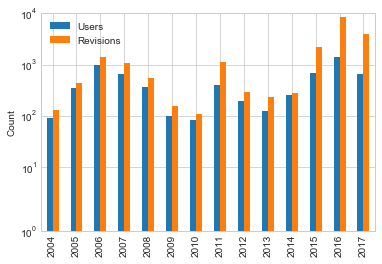

In [78]:
ax = trump_rev_df.groupby('year').agg({'user':pd.Series.nunique,'sha1':pd.Series.nunique}).plot(kind='bar',legend=False)
ax.set_ylim(1,1e4)
ax.set_yscale('symlog')
ax.set_xlabel('')
ax.set_ylabel('Count')
plt.legend(['Users','Revisions'])

Text(0,0.5,'Unique editors')

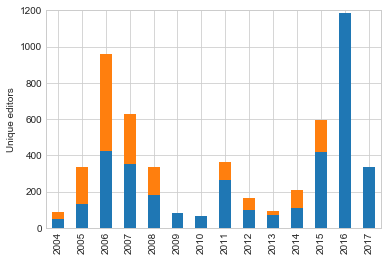

In [79]:
editors_counts_df = pd.DataFrame({'All':{k:len(v) for k,v in all_trump_cohorts_d.items()},'Registered':{k:len(v) for k,v in reg_trump_cohorts_d.items()}})
editors_counts_df.index = range(2004,2018)
editors_counts_df['Anonymous'] = editors_counts_df['All'] - editors_counts_df['Registered']

f,ax = plt.subplots(1,1,figsize=(6,4))
editors_counts_df[['Registered','Anonymous']].plot(kind='bar',legend=False,stacked=True,ax=ax)

ax.set_ylim((0,1200))
ax.set_ylabel('Unique editors')
#plt.legend(loc='center left',ncol=2,bbox_to_anchor=(.2,-.2))

### User cohorts

In [80]:
trump_cohort_annual_revs = {}
trump_cohort_annual_frac = {}

for _year,_users in all_trump_cohorts_d.items():
    trump_cohort_annual_revs[_year] = {}
    trump_cohort_annual_frac[_year] = {}
    for _annual in range(2004,2018):
        cohort_revs = len(trump_rev_df[(trump_rev_df['user'].isin(_users)) & (trump_rev_df['year'] == _annual)])
        annual_revs = len(trump_rev_df[(trump_rev_df['year'] == _annual)])
        trump_cohort_annual_revs[_year][_annual] = cohort_revs
        trump_cohort_annual_frac[_year][_annual] = cohort_revs/annual_revs
        
clinton_cohort_annual_revs = {}
clinton_cohort_annual_frac = {}

for _year,_users in all_clinton_cohorts_d.items():
    clinton_cohort_annual_revs[_year] = {}
    clinton_cohort_annual_frac[_year] = {}
    for _annual in range(2001,2018):
        cohort_revs = len(clinton_rev_df[(clinton_rev_df['user'].isin(_users)) & (clinton_rev_df['year'] == _annual)])
        annual_revs = len(clinton_rev_df[(clinton_rev_df['year'] == _annual)])
        clinton_cohort_annual_revs[_year][_annual] = cohort_revs
        clinton_cohort_annual_frac[_year][_annual] = cohort_revs/annual_revs

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\scale.py:290: RuntimeWarning: invalid value encountered in sign
  sign = np.sign(a)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\ma\core.py:2166: RuntimeWarning: invalid value encountered in greater_equal
  condition = (xf >= v1) & (xf <= v2)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\ma\core.py:2166: RuntimeWarning: invalid value encountered in less_equal
  condition = (xf >= v1) & (xf <= v2)


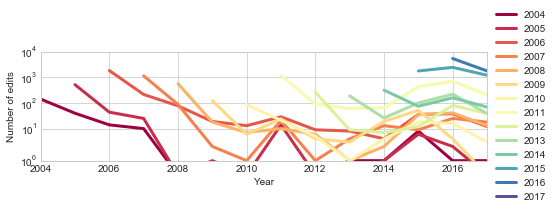

In [81]:
trump_cohort_annual_revs_df = pd.DataFrame(trump_cohort_annual_revs)
# https://stackoverflow.com/questions/45631288/stack-a-square-dataframe-to-only-keep-the-upper-lower-triangle
trump_cohort_annual_revs_df = trump_cohort_annual_revs_df.mask(np.triu(np.ones(trump_cohort_annual_revs_df.shape),1).astype(bool))

f,ax = plt.subplots(1,1,figsize=(8,2))
trump_cohort_annual_revs_df.plot(kind='line',ax=ax,legend=False,colormap='Spectral',lw=3)
ax.set_yscale('symlog')
ax.set_ylim((1e0,1e4))
ax.set_xlabel('Year')
ax.set_ylabel('Number of edits')
plt.legend(loc='center left',bbox_to_anchor=(1,.5))

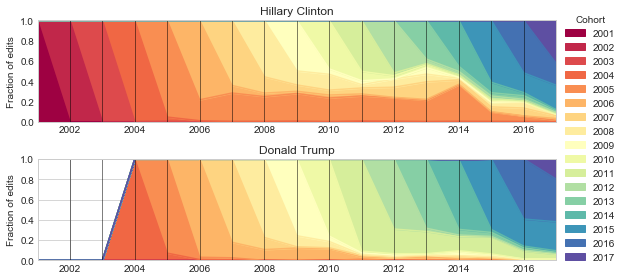

In [82]:
clinton_cohort_annual_frac_df = pd.DataFrame(clinton_cohort_annual_frac)
clinton_cohort_annual_frac_df.columns = range(2001,2018)
trump_cohort_annual_frac_df = pd.DataFrame(trump_cohort_annual_frac)
trump_cohort_annual_frac_df.columns = range(2004,2018)

trump_cohort_annual_frac_df = trump_cohort_annual_frac_df.reindex_like(clinton_cohort_annual_frac_df)#.fillna(0)

# https://stackoverflow.com/questions/45631288/stack-a-square-dataframe-to-only-keep-the-upper-lower-triangle
trump_cohort_annual_frac_df = trump_cohort_annual_frac_df.mask(np.triu(np.ones(trump_cohort_annual_frac_df.shape),1).astype(bool))
clinton_cohort_annual_frac_df = clinton_cohort_annual_frac_df.mask(np.triu(np.ones(clinton_cohort_annual_frac_df.shape),1).astype(bool))

# Plot
f,axs = plt.subplots(2,1,figsize=(8,4))

clinton_cohort_annual_frac_df.plot(kind='area',legend=False,colormap='Spectral',ax=axs[0])
axs[0].set_ylim((0,1))
axs[0].set_xlabel('')
axs[0].set_ylabel('Fraction of edits')
axs[0].set_title('Hillary Clinton')

trump_cohort_annual_frac_df.plot(kind='area',legend=False,colormap='Spectral',ax=axs[1])
axs[1].set_ylim((0,1))
axs[1].set_xlabel('')
axs[1].set_ylabel('Fraction of edits')
axs[1].set_title('Donald Trump')

plt.legend(title='Cohort',loc='center left',bbox_to_anchor=(1,1.2))
plt.tight_layout()

for year in range(2002,2017):
    axs[0].axvline(year,color='k',lw=.5)
    axs[1].axvline(year,color='k',lw=.5)

plt.savefig('cohort_fraction_edits.pdf',dpi=300,bbox_inches='tight')

Clinton's 2005 cohort seems to have maintained an unusually high level of activity over a decade.

In [83]:
clinton_cohort_annual_frac_df.loc[:,2005]

2001         NaN
2002         NaN
2003         NaN
2004         NaN
2005    0.953989
2006    0.206378
2007    0.282664
2008    0.246247
2009    0.273649
2010    0.234146
2011    0.248366
2012    0.231818
2013    0.211356
2014    0.360248
2015    0.093126
2016    0.055529
2017    0.013725
Name: 2005, dtype: float64

Which cohorts were most active during the campaign?

In [84]:
clinton_cohort_annual_frac_df.loc[2016,:]

2001    0.000000
2002    0.000000
2003    0.000000
2004    0.000000
2005    0.055529
2006    0.002373
2007    0.077361
2008    0.059326
2009    0.003322
2010    0.003797
2011    0.007119
2012    0.012814
2013    0.035121
2014    0.031324
2015    0.194115
2016    0.517798
2017         NaN
Name: 2016, dtype: float64

In [85]:
trump_cohort_annual_frac_df.loc[2016,:]

2001         NaN
2002         NaN
2003         NaN
2004    0.000107
2005    0.000215
2006    0.004076
2007    0.002682
2008    0.004398
2009    0.000429
2010    0.001716
2011    0.077014
2012    0.008688
2013    0.023812
2014    0.017162
2015    0.267403
2016    0.592299
2017         NaN
Name: 2016, dtype: float64

Which cohorts were active in 2017?

In [86]:
clinton_cohort_annual_frac_df.loc[2017,:]

2001    0.000000
2002    0.000000
2003    0.000000
2004    0.000000
2005    0.013725
2006    0.017647
2007    0.027451
2008    0.013725
2009    0.001961
2010    0.000000
2011    0.011765
2012    0.005882
2013    0.019608
2014    0.007843
2015    0.241176
2016    0.215686
2017    0.423529
Name: 2017, dtype: float64

In [87]:
trump_cohort_annual_frac_df.loc[2017,:]

2001         NaN
2002         NaN
2003         NaN
2004    0.000233
2005    0.000000
2006    0.002799
2007    0.004198
2008    0.003032
2009    0.000000
2010    0.000700
2011    0.048974
2012    0.009095
2013    0.009095
2014    0.016325
2015    0.286381
2016    0.421409
2017    0.197761
Name: 2017, dtype: float64

Was it one or many editors from the 2005 cohort who remained active over time?

In [88]:
clinton_rev_df[(clinton_rev_df['user'].isin(all_clinton_cohorts_d['2007'])) & (clinton_rev_df['year'] == 2016)]['user'].value_counts()

Anythingyouwant        129
Tvoz                     9
Timrollpickering         6
All Hallow's Wraith      4
Jennica                  3
Coffee                   3
CommonsDelinker          1
JamesReyes               1
Wester                   1
Bearcat                  1
Acroterion               1
Jauerback                1
Chris the speller        1
Seraphimblade            1
Kaldari                  1
Name: user, dtype: int64

### Unique users

In [90]:
daily_trump_editors_s = trump_rev_df.groupby(['date']).apply(lambda x:x['user'].unique())
daily_clinton_editors_s = clinton_rev_df.groupby(['date']).apply(lambda x:x['user'].unique())

daily_trump_editors_l = [set(daily_trump_editors_s.values[0])]
daily_clinton_editors_l = [set(daily_clinton_editors_s.values[0])]

for i,user_set in enumerate(daily_trump_editors_s.values):
    if i>0:
        daily_trump_editors_l.append(set(daily_trump_editors_l[i-1]) | set(user_set))
        
for i,user_set in enumerate(daily_clinton_editors_s.values):
    if i>0:
        daily_clinton_editors_l.append(set(daily_clinton_editors_l[i-1]) | set(user_set))
        
daily_c_clinton_editors = pd.Series(index=daily_clinton_editors_s.index,data=daily_clinton_editors_l).reindex(pd.date_range('2002-01-01','2017-11-09'))
daily_c_trump_editors = pd.Series(index=daily_trump_editors_s.index,data=daily_trump_editors_l).reindex(pd.date_range('2002-01-01','2017-11-09'))

daily_c_clinton_editors.loc['2002-01-01'] = set()
daily_c_trump_editors.loc['2002-01-01'] = set()

daily_c_clinton_editors.fillna(method='ffill',inplace=True)
daily_c_trump_editors.fillna(method='ffill',inplace=True)

daily_cumulative_editors = pd.DataFrame({'Trump':daily_c_trump_editors,'Clinton':daily_c_clinton_editors})
daily_cumulative_editors_counts = pd.DataFrame({'Trump':daily_c_trump_editors.apply(len),'Clinton':daily_c_clinton_editors.apply(len)})
daily_cumulative_editors_counts.fillna(method='ffill',inplace=True)

In [93]:
len(daily_reg_trump_editors_l)

5792

In [91]:
reg_trump_users = set(trump_rev_df[(trump_rev_df['anon'] == 0)]['user'].unique())
reg_clinton_users = set(clinton_rev_df[(clinton_rev_df['anon'] == 0)]['user'].unique())

daily_reg_trump_editors_l = []
daily_reg_clinton_editors_l = []

for user_set in daily_c_trump_editors:
    daily_reg_trump_editors_l.append(set(user_set) - reg_trump_users)
        
for user_set in daily_c_clinton_editors:
    daily_reg_clinton_editors_l.append(set(user_set) - reg_clinton_users)
        
daily_c_trump_reg_editors = pd.Series(index=daily_trump_editors_s.index,data=daily_reg_trump_editors_l)
daily_c_clinton_reg_editors = pd.Series(index=daily_clinton_editors_s.index,data=daily_reg_clinton_editors_l)

daily_cumulative_reg_editors_counts = pd.DataFrame({'Trump':daily_c_trump_reg_editors.apply(len),'Clinton':daily_c_clinton_reg_editors.apply(len)})
daily_cumulative_reg_editors_counts.fillna(method='ffill',inplace=True)

ValueError: Wrong number of items passed 5792, placement implies 2694

In [ ]:
bots_clinton = set(clinton_rev_df[clinton_rev_df['user'].isin(bot_list)]['user'].unique())
bots_trump = set(trump_rev_df[trump_rev_df['user'].isin(bot_list)]['user'].unique())

daily_bot_trump_editors_l = []
daily_bot_clinton_editors_l = []

for user_set in daily_c_clinton_editors:
    daily_bot_clinton_editors_l.append(set(user_set) & bots_clinton)

for user_set in daily_c_trump_editors:
    daily_bot_trump_editors_l.append(set(user_set) & bots_trump)
        
daily_c_clinton_bot_editors = pd.Series(index=daily_clinton_editors_s.index,data=daily_bot_clinton_editors_l)
daily_c_trump_bot_editors = pd.Series(index=daily_trump_editors_s.index,data=daily_bot_trump_editors_l)

daily_cumulative_bot_editors_counts = pd.DataFrame({'Trump':daily_c_trump_bot_editors.apply(len),'Clinton':daily_c_clinton_bot_editors.apply(len)})
daily_cumulative_bot_editors_counts.fillna(method='ffill',inplace=True)

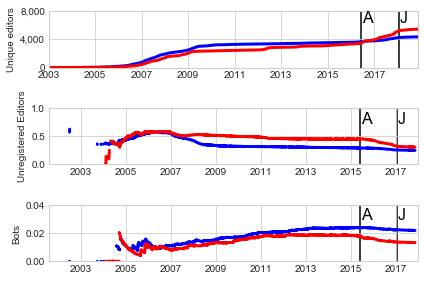

In [811]:
f,axs = plt.subplots(3,figsize=(6,4))

daily_cumulative_editors_counts.plot(color=['b','r'],lw=3,legend=False,ax=axs[0])
axs[0].set_ylim((0,8000))
axs[0].set_ylabel('Unique editors')
axs[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
axs[0].set_xlabel('')
axs[0].set_xticklabels(range(2003,2018,2),rotation=0,ha='center')
axs[0].set_yticks([0,4000,8000])

(daily_cumulative_reg_editors_counts/daily_cumulative_editors_counts).plot(color=['b','r'],lw=3,legend=False,ax=axs[1])
axs[1].set_ylim((0,1))
axs[1].set_ylabel('Unregistered Editors')
axs[1].set_xlabel('')
axs[1].set_xticklabels(range(2003,2018,2),rotation=0,ha='center')

(daily_cumulative_bot_editors_counts/daily_cumulative_editors_counts).plot(color=['b','r'],lw=3,legend=False,ax=axs[2])
axs[2].set_ylim((0,.04))
axs[2].set_ylabel('Bots')
axs[2].set_xlabel('')
axs[2].set_xticklabels(range(2003,2018,2),rotation=0,ha='center')

axs[0].axvline(pd.Timestamp('2015-06-01'),color='k',zorder=-1) # Announcement
axs[0].annotate('A',xy=(pd.Timestamp('2015-06-15'),7000),va="center", ha="left", color='k', size=16)

axs[0].axvline(pd.Timestamp('2017-01-20'),color='k',zorder=-1) # Inauguration
axs[0].annotate('J',xy=(pd.Timestamp('2017-02-05'),7000),va="center", ha="left", color='k', size=16)

axs[1].axvline(pd.Timestamp('2015-06-01'),color='k',zorder=-1) # Announcement
axs[1].annotate('A',xy=(pd.Timestamp('2015-06-15'),.8),va="center", ha="left", color='k', size=16)

axs[1].axvline(pd.Timestamp('2017-01-20'),color='k',zorder=-1) # Inauguration
axs[1].annotate('J',xy=(pd.Timestamp('2017-02-05'),.8),va="center", ha="left", color='k', size=16)

axs[2].axvline(pd.Timestamp('2015-06-01'),color='k',zorder=-1) # Announcement
axs[2].annotate('A',xy=(pd.Timestamp('2015-06-15'),.0325),va="center", ha="left", color='k', size=16)

axs[2].axvline(pd.Timestamp('2017-01-20'),color='k',zorder=-1) # Inauguration
axs[2].annotate('J',xy=(pd.Timestamp('2017-02-05'),.0325),va="center", ha="left", color='k', size=16)

plt.tight_layout()
plt.savefig('cumulative_users.pdf')

In [371]:
daily_cumulative_editors_counts.loc['2015-01-01']

Clinton    3581.0
Trump      3332.0
Name: 2015-01-01 00:00:00, dtype: float64

In [373]:
daily_cumulative_editors_counts.loc['2015-06-13']

Clinton    3652.0
Trump      3432.0
Name: 2015-06-13 00:00:00, dtype: float64

In [372]:
daily_cumulative_editors_counts.loc['2016-11-08']

Clinton    4145.0
Trump      4773.0
Name: 2016-11-08 00:00:00, dtype: float64

How much did the number of editors increase over the course of the campaign?

In [517]:
print("Trump: {0:.1%}".format((daily_cumulative_editors_counts.loc['2016-11-08','Trump'] - daily_cumulative_editors_counts.loc['2015-06-01','Trump'])/daily_cumulative_editors_counts.loc['2015-06-01','Trump']))
print("Clinton: {0:.1%}".format((daily_cumulative_editors_counts.loc['2016-11-08','Clinton'] - daily_cumulative_editors_counts.loc['2015-06-01','Clinton'])/daily_cumulative_editors_counts.loc['2015-06-01','Clinton']))

Trump: 39.6%
Clinton: 13.8%


### Revision fractions

In [94]:
clinton_daily_c_revs = clinton_rev_df.groupby('date').agg({'revid':pd.Series.nunique})['revid'].reindex(pd.date_range('2002-01-01','2017-11-09')).fillna(0).cumsum()
trump_daily_c_revs = trump_rev_df.groupby('date').agg({'revid':pd.Series.nunique})['revid'].reindex(pd.date_range('2002-01-01','2017-11-09')).fillna(0).cumsum()
related_clinton_daily_c_revs = all_clinton_rev_df[(all_clinton_rev_df['page'] != 'Hillary Clinton')].groupby('date').agg({'revid':pd.Series.nunique})['revid'].reindex(pd.date_range('2002-01-01','2017-11-09')).fillna(0).cumsum()
related_trump_daily_c_revs = all_trump_rev_df[(all_trump_rev_df['page'] != 'Donald Trump')].groupby('date').agg({'revid':pd.Series.nunique})['revid'].reindex(pd.date_range('2002-01-01','2017-11-09')).fillna(0).cumsum()

reg_clinton_users = set(clinton_rev_df[(clinton_rev_df['anon'] == 0)]['user'].unique())
reg_trump_users = set(trump_rev_df[(trump_rev_df['anon'] == 0)]['user'].unique())
reg_clinton_related_users = set(all_clinton_rev_df[(all_clinton_rev_df['anon'] == 0) & (all_clinton_rev_df['page'] != 'Hillary Clinton')]['user'].unique())
reg_trump_related_users = set(all_trump_rev_df[(all_trump_rev_df['anon'] == 0) & (all_trump_rev_df['page'] != 'Donald Trump')]['user'].unique())

bots_clinton = set(clinton_rev_df[clinton_rev_df['user'].isin(bot_list)]['user'].unique())
bots_trump = set(trump_rev_df[trump_rev_df['user'].isin(bot_list)]['user'].unique())
bots_clinton_related = set(all_clinton_rev_df[(all_clinton_rev_df['user'].isin(bot_list)) & (all_clinton_rev_df['page'] != 'Hillary Clinton')]['user'].unique())
bots_trump_related = set(all_trump_rev_df[(all_trump_rev_df['user'].isin(bot_list)) & (all_trump_rev_df['page'] != 'Donald Trump')]['user'].unique())

clinton_reg_revs = clinton_rev_df[clinton_rev_df['user'].isin(reg_clinton_users)].groupby('date').agg({'revid':pd.Series.nunique})['revid'].reindex(pd.date_range('2002-01-01','2017-11-09')).fillna(0).cumsum()
trump_reg_revs = trump_rev_df[trump_rev_df['user'].isin(reg_trump_users)].groupby('date').agg({'revid':pd.Series.nunique})['revid'].reindex(pd.date_range('2002-01-01','2017-11-09')).fillna(0).cumsum()
clinton_related_reg_revs = all_clinton_rev_df[(all_clinton_rev_df['user'].isin(reg_clinton_related_users)) & (all_clinton_rev_df['page'] != 'Hillary Clinton')].groupby('date').agg({'revid':pd.Series.nunique})['revid'].reindex(pd.date_range('2002-01-01','2017-11-09')).fillna(0).cumsum()
trump_related_reg_revs = all_trump_rev_df[(all_trump_rev_df['user'].isin(reg_trump_related_users)) & (all_trump_rev_df['page'] != 'Donald Trump')].groupby('date').agg({'revid':pd.Series.nunique})['revid'].reindex(pd.date_range('2002-01-01','2017-11-09')).fillna(0).cumsum()

clinton_bot_revs = clinton_rev_df[clinton_rev_df['user'].isin(bot_list)].groupby('date').agg({'revid':pd.Series.nunique})['revid'].reindex(pd.date_range('2002-01-01','2017-11-09')).fillna(0).cumsum()
trump_bot_revs = trump_rev_df[trump_rev_df['user'].isin(bot_list)].groupby('date').agg({'revid':pd.Series.nunique})['revid'].reindex(pd.date_range('2002-01-01','2017-11-09')).fillna(0).cumsum()
clinton_related_bot_revs = all_clinton_rev_df[(all_clinton_rev_df['user'].isin(bot_list)) & (all_clinton_rev_df['page'] != 'Hillary Clinton')].groupby('date').agg({'revid':pd.Series.nunique})['revid'].reindex(pd.date_range('2002-01-01','2017-11-09')).fillna(0).cumsum()
trump_related_bot_revs = all_trump_rev_df[(all_trump_rev_df['user'].isin(bot_list)) & (all_trump_rev_df['page'] != 'Donald Trump')].groupby('date').agg({'revid':pd.Series.nunique})['revid'].reindex(pd.date_range('2002-01-01','2017-11-09')).fillna(0).cumsum()

reg_rev_fraction_df = pd.DataFrame({'Clinton':clinton_reg_revs/clinton_daily_c_revs,
                                    'Trump':trump_reg_revs/trump_daily_c_revs,
                                    'Clinton-related':clinton_related_reg_revs/related_clinton_daily_c_revs,
                                    'Trump-related':trump_related_reg_revs/related_trump_daily_c_revs})

bot_rev_fraction_df = pd.DataFrame({'Clinton':clinton_bot_revs/clinton_daily_c_revs,
                                    'Trump':trump_bot_revs/trump_daily_c_revs,
                                    'Clinton-related':clinton_related_bot_revs/related_clinton_daily_c_revs,
                                    'Trump-related':trump_related_bot_revs/related_trump_daily_c_revs})

_col_order = ['Clinton','Trump','Clinton-related','Trump-related']
reg_rev_fraction_df = reg_rev_fraction_df[_col_order]
bot_rev_fraction_df = bot_rev_fraction_df[_col_order]

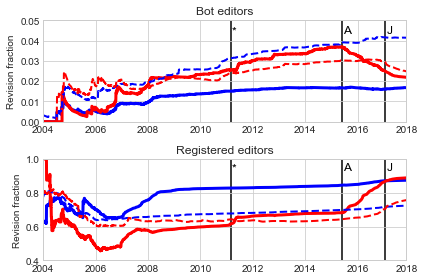

In [95]:
styles = ['b-','r-','b--','r--']
widths = [3,3,2,2]

f,axs = plt.subplots(2,figsize=(6,4))

# bot_rev_fraction_df.loc['2004-01-01':].plot(lw=3,legend=False,ax=axs[0])
for _col,_s,_w in zip(bot_rev_fraction_df.columns,styles,widths):
    bot_rev_fraction_df.loc['2004-01-01':,_col].plot(style=_s,lw=_w,legend=False,ax=axs[0])

axs[0].set_ylim((0,0.05))
axs[0].set_ylabel('Revision fraction')
axs[0].set_xlabel('')
axs[0].set_xticklabels(range(2004,2019,2),rotation=0,ha='center')
axs[0].set_title('Bot editors')

#reg_rev_fraction_df.loc['2004-01-01':].plot(color=['b','r','b','r'],lw=3,legend=False,ax=axs[1])
for _col,_s,_w in zip(reg_rev_fraction_df.columns,styles,widths):
    reg_rev_fraction_df.loc['2004-01-01':,_col].plot(style=_s,lw=_w,legend=False,ax=axs[1])

axs[1].set_ylim((.4,1))
axs[1].set_ylabel('Revision fraction')
axs[1].set_xlabel('')
axs[1].set_xticklabels(range(2004,2019,2),rotation=0,ha='center')
axs[1].set_title('Registered editors')

axs[0].axvline(pd.Timestamp('2015-06-01'),color='k',zorder=-1) # Announcement
axs[0].annotate('A',xy=(pd.Timestamp('2015-06-15'),0.045),va="center", ha="left", color='k', size=12)

axs[0].axvline(pd.Timestamp('2017-01-20'),color='k',zorder=-1) # Inauguration
axs[0].annotate('J',xy=(pd.Timestamp('2017-02-05'),0.045),va="center", ha="left", color='k', size=12)

axs[0].axvline(pd.Timestamp('2011-03-01'),color='k',zorder=-1) # Birther
axs[0].annotate('*',xy=(pd.Timestamp('2011-03-15'),0.045),va="center", ha="left", color='k', size=12)

axs[1].axvline(pd.Timestamp('2015-06-01'),color='k',zorder=-1) # Announcement
axs[1].annotate('A',xy=(pd.Timestamp('2015-06-15'),.95),va="center", ha="left", color='k', size=12)

axs[1].axvline(pd.Timestamp('2017-01-20'),color='k',zorder=-1) # Inauguration
axs[1].annotate('J',xy=(pd.Timestamp('2017-02-05'),.95),va="center", ha="left", color='k', size=12)

axs[1].axvline(pd.Timestamp('2011-03-01'),color='k',zorder=-1) # Birther
axs[1].annotate('*',xy=(pd.Timestamp('2011-03-15'),.95),va="center", ha="left", color='k', size=12)

plt.tight_layout()
plt.savefig('user_types.pdf')

### Editor overlaps

In [96]:
related_clinton_rev_df = all_clinton_rev_df[(all_clinton_rev_df['page'] != 'Hillary Clinton') & (~all_clinton_rev_df['user'].isin(bot_list)) & (all_clinton_rev_df['anon'] == False)]
related_trump_rev_df = all_trump_rev_df[(all_trump_rev_df['page'] != 'Donald Trump') & (~all_trump_rev_df['user'].isin(bot_list)) & (all_trump_rev_df['anon'] == False)]

clinton_articles_c_users = clinton_rev_df.groupby('date')['user'].apply(set).reindex(pd.date_range('2002-01-01','2017-11-09'))
trump_articles_c_users = trump_rev_df.groupby('date')['user'].apply(set).reindex(pd.date_range('2002-01-01','2017-11-09'))
related_clinton_articles_c_users = related_clinton_rev_df.groupby('date')['user'].apply(set).reindex(pd.date_range('2002-01-01','2017-11-09'))
related_trump_articles_c_users = related_trump_rev_df.groupby('date')['user'].apply(set).reindex(pd.date_range('2002-01-01','2017-11-09'))

clinton_articles_c_users.loc['2002-01-01'] = set()
trump_articles_c_users.loc['2002-01-01'] = set()
related_clinton_articles_c_users.loc['2002-01-01'] = set()
related_trump_articles_c_users.loc['2002-01-01'] = set()

clinton_articles_c_users.fillna(method='ffill',inplace=True)
trump_articles_c_users.fillna(method='ffill',inplace=True)
related_clinton_articles_c_users.fillna(method='ffill',inplace=True)
related_trump_articles_c_users.fillna(method='ffill',inplace=True)

clinton_articles_c_users = clinton_articles_c_users.apply(list).cumsum().apply(set)
trump_articles_c_users = trump_articles_c_users.apply(list).cumsum().apply(list_set)
related_clinton_articles_c_users = related_clinton_articles_c_users.apply(list).cumsum().apply(set)
related_trump_articles_c_users = related_trump_articles_c_users.apply(list).cumsum().apply(set)

In [97]:
def jaccard(s1,s2):
    if len(s1 | s2) > 0:
        return len(s1 & s2)/len(s1 | s2)
    else:
        return 0

# Intersection sets
clinton_and_trump_i = {}
clinton_and_clinton_related_i = {}
clinton_and_trump_related_i = {}
clinton_related_and_trump_related_i = {}
trump_and_clinton_related_i = {}
trump_and_trump_related_i = {}


# Jaccard coefficients
clinton_and_trump_j = {}
clinton_and_clinton_related_j = {}
clinton_and_trump_related_j = {}
clinton_related_and_trump_related_j = {}
trump_and_clinton_related_j = {}
trump_and_trump_related_j = {}

for ts in daily_c_clinton_editors.index:
    _clinton_editors = set(clinton_articles_c_users.loc[ts])
    _trump_editors = set(trump_articles_c_users.loc[ts])
    _related_clinton_editors = set(related_clinton_articles_c_users.loc[ts])
    _related_trump_editors = set(related_trump_articles_c_users.loc[ts])
    
    clinton_and_trump_i[ts] = _clinton_editors & _trump_editors
    clinton_and_clinton_related_i[ts] = _clinton_editors & _related_clinton_editors
    clinton_and_trump_related_i[ts] = _clinton_editors & _related_trump_editors
    clinton_related_and_trump_related_i[ts] = _related_clinton_editors & _related_trump_editors
    trump_and_clinton_related_i[ts] = _trump_editors & _related_clinton_editors
    trump_and_trump_related_i[ts] = _trump_editors & _related_trump_editors
    
    clinton_and_trump_j[ts] = jaccard(_clinton_editors,_trump_editors)
    clinton_and_clinton_related_j[ts] = jaccard(_clinton_editors,_related_clinton_editors)
    clinton_and_trump_related_j[ts] = jaccard(_clinton_editors,_related_trump_editors)
    clinton_related_and_trump_related_j[ts] = jaccard(_related_clinton_editors,_related_trump_editors)
    trump_and_clinton_related_j[ts] = jaccard(_trump_editors,_related_clinton_editors)
    trump_and_trump_related_j[ts] = jaccard(_trump_editors,_related_trump_editors)

Calculate revisions from editors in the intersection.

In [98]:
_last = pd.Timestamp('2017-11-09')
clinton_and_trump_revs = clinton_rev_df[clinton_rev_df['user'].isin(clinton_and_trump_i[_last])].groupby('date').agg({'revid':pd.Series.nunique})['revid'].reindex(pd.date_range('2002-01-01','2017-11-09')).fillna(0).cumsum()
clinton_and_clinton_related_revs = clinton_rev_df[clinton_rev_df['user'].isin(clinton_and_clinton_related_i[_last])].groupby('date').agg({'revid':pd.Series.nunique})['revid'].reindex(pd.date_range('2002-01-01','2017-11-09')).fillna(0).cumsum()
clinton_and_trump_related_revs = clinton_rev_df[clinton_rev_df['user'].isin(clinton_and_trump_related_i[_last])].groupby('date').agg({'revid':pd.Series.nunique})['revid'].reindex(pd.date_range('2002-01-01','2017-11-09')).fillna(0).cumsum()
clinton_and_both_related_revs = clinton_rev_df[clinton_rev_df['user'].isin(clinton_related_and_trump_related_i[_last])].groupby('date').agg({'revid':pd.Series.nunique})['revid'].reindex(pd.date_range('2002-01-01','2017-11-09')).fillna(0).cumsum()
trump_and_clinton_revs = trump_rev_df[trump_rev_df['user'].isin(clinton_and_trump_i[_last])].groupby('date').agg({'revid':pd.Series.nunique})['revid'].reindex(pd.date_range('2002-01-01','2017-11-09')).fillna(0).cumsum()
trump_and_clinton_related_revs = trump_rev_df[trump_rev_df['user'].isin(trump_and_clinton_related_i[_last])].groupby('date').agg({'revid':pd.Series.nunique})['revid'].reindex(pd.date_range('2002-01-01','2017-11-09')).fillna(0).cumsum()
trump_and_trump_related_revs = trump_rev_df[trump_rev_df['user'].isin(trump_and_trump_related_i[_last])].groupby('date').agg({'revid':pd.Series.nunique})['revid'].reindex(pd.date_range('2002-01-01','2017-11-09')).fillna(0).cumsum()
trump_and_both_related_revs = trump_rev_df[trump_rev_df['user'].isin(clinton_related_and_trump_related_i[_last])].groupby('date').agg({'revid':pd.Series.nunique})['revid'].reindex(pd.date_range('2002-01-01','2017-11-09')).fillna(0).cumsum()

Plot.

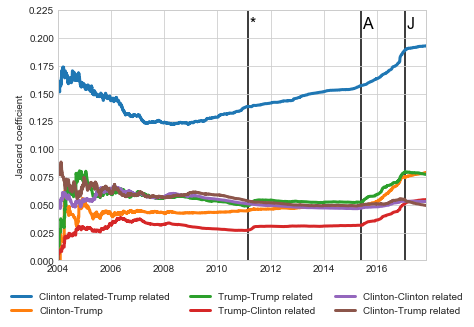

In [99]:
editor_jaccard_df = pd.DataFrame({'Clinton-Trump':clinton_and_trump_j,
                                  'Clinton-Clinton related':clinton_and_clinton_related_j,
                                  'Clinton-Trump related':clinton_and_trump_related_j,
                                  'Clinton related-Trump related':clinton_related_and_trump_related_j,
                                  'Trump-Clinton related':trump_and_clinton_related_j,
                                  'Trump-Trump related':trump_and_trump_related_j})

f,ax = plt.subplots(1,figsize=(6,4))
_cols = editor_jaccard_df.loc['2017-11-09'].sort_values(ascending=False).index
editor_jaccard_df.loc['2004-01-01':,_cols].plot(lw=3,legend=False,ax=ax)
ax.set_ylim(0,.225)
#ax.set_yscale('log')
ax.set_ylabel('Jaccard coefficient')

ax.axvline(pd.Timestamp('2015-06-01'),color='k',zorder=-1) # Announcement
ax.annotate('A',xy=(pd.Timestamp('2015-06-15'),0.2125),va="center", ha="left", color='k', size=16)

ax.axvline(pd.Timestamp('2017-01-20'),color='k',zorder=-1) # Inauguration
ax.annotate('J',xy=(pd.Timestamp('2017-02-15'),0.2125),va="center", ha="left", color='k', size=16)

ax.axvline(pd.Timestamp('2011-03-01'),color='k',zorder=-1) # Inauguration
ax.annotate('*',xy=(pd.Timestamp('2011-03-15'),0.2125),va="center", ha="left", color='k', size=16)

plt.legend(loc='center left',bbox_to_anchor = (-.15,-.175),ncol=3)
plt.tight_layout()
plt.savefig('editor_jaccard.pdf',bbox_inches='tight',dpi=300)

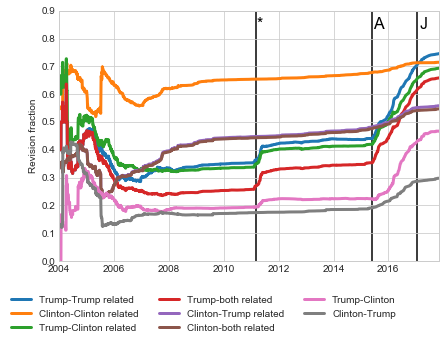

In [101]:
overlap_rev_fraction_df = pd.DataFrame({'Clinton-Trump':clinton_and_trump_revs/clinton_daily_c_revs,
                                        'Clinton-Clinton related':clinton_and_clinton_related_revs/clinton_daily_c_revs,
                                        'Clinton-Trump related':clinton_and_trump_related_revs/clinton_daily_c_revs,
                                        'Clinton-both related':clinton_and_both_related_revs/clinton_daily_c_revs,
                                        'Trump-Clinton':trump_and_clinton_revs/trump_daily_c_revs,
                                        'Trump-Clinton related':trump_and_clinton_related_revs/trump_daily_c_revs,
                                        'Trump-Trump related':trump_and_trump_related_revs/trump_daily_c_revs,
                                        'Trump-both related':trump_and_both_related_revs/trump_daily_c_revs})

f,ax = plt.subplots(1,figsize=(6,4))
_cols = overlap_rev_fraction_df.loc['2017-11-09'].sort_values(ascending=False).index
overlap_rev_fraction_df.loc['2004-01-01':,_cols].plot(lw=3,legend=False,ax=ax)
ax.set_ylim(0,.9)
#ax.set_yscale('log')
ax.set_ylabel('Revision fraction')

ax.axvline(pd.Timestamp('2015-06-01'),color='k',zorder=-1) # Announcement
ax.annotate('A',xy=(pd.Timestamp('2015-06-15'),0.85),va="center", ha="left", color='k', size=16)

ax.axvline(pd.Timestamp('2017-01-20'),color='k',zorder=-1) # Inauguration
ax.annotate('J',xy=(pd.Timestamp('2017-02-15'),0.85),va="center", ha="left", color='k', size=16)

ax.axvline(pd.Timestamp('2011-03-01'),color='k',zorder=-1) # Inauguration
ax.annotate('*',xy=(pd.Timestamp('2011-03-15'),0.85),va="center", ha="left", color='k', size=16)

plt.legend(loc='center left',bbox_to_anchor = (-.15,-.2125),ncol=3)
plt.tight_layout()
plt.savefig('editor_rev_fraction.pdf',bbox_inches='tight',dpi=300)

In [1186]:
overlap_rev_fraction_df.loc['2015-01-01','Clinton-Clinton related'], overlap_rev_fraction_df.loc['2016-11-08','Clinton-Clinton related']

(0.67395953281789767, 0.71154233532532063)

In [1187]:
overlap_rev_fraction_df.loc['2015-01-01','Trump-Trump related'], overlap_rev_fraction_df.loc['2016-11-08','Trump-Trump related']

(0.43670970318115265, 0.67735564075752297)

In [1188]:
overlap_rev_fraction_df.loc['2015-01-01','Trump-Clinton related'], overlap_rev_fraction_df.loc['2016-11-08','Trump-Clinton related']

(0.41421536004259285, 0.62867433484373181)

### Predecessor and successor collaborations

In [102]:
with open('active_users_clinton.json','r') as f:
    clinton_active_user_list = list(set(json.load(f)))

with open('active_users_trump.json','r') as f:
    trump_active_user_list = list(set(json.load(f)))
    
with open('active_users_both.json','r') as f:
    both_active_user_list = list(set(json.load(f)))
    
with open('userinfo_active_users_both.json','r') as f:
    both_active_userinfo = json.load(f)

print("{0:,} Clinton active users".format(len(clinton_active_user_list)))
print("{0:,} Trump active users".format(len(trump_active_user_list)))
print("{0:,} both active users".format(len(both_active_user_list)))
    
union_active_user_list =  list(set(clinton_active_user_list) | set(trump_active_user_list))
intersection_active_user_list =  list(set(clinton_active_user_list) & set(trump_active_user_list))
clinton_only_active_user_list = list(set(both_active_user_list) - set(trump_active_user_list))
trump_only_active_user_list = list(set(both_active_user_list) - set(clinton_active_user_list))

# There are users who fulfill the criteria when considering Clinton and Trump jointly, but not individually
#diff_active_user_list = list(set(both_active_user_list) - set(union_active_user_list))

print("SANITY CHECK: {0:,} union active users".format(len(union_active_user_list)))
print("{0:,} intersection active users".format(len(intersection_active_user_list)))
#print("{0:,} diff active users".format(len(diff_active_user_list)))
print("{0:,} Clinton-only active users".format(len(clinton_only_active_user_list)))
print("{0:,} Trump-only active users".format(len(trump_only_active_user_list)))

print("\n{0:,} users with userinfo".format(len(both_active_userinfo)))

2,467 Clinton active users
2,969 Trump active users
3,016 both active users
SANITY CHECK: 3,016 union active users
2,420 intersection active users
47 Clinton-only active users
549 Trump-only active users

2,956 users with userinfo


In [103]:
len(intersection_active_user_list)/len(union_active_user_list)

0.8023872679045093

In [104]:
clinton_user_first_edits = all_clinton_rev_df.groupby('user').agg({'timestamp':np.min})['timestamp'].reset_index()
trump_user_first_edits = all_trump_rev_df.groupby('user').agg({'timestamp':np.min})['timestamp'].reset_index()
both_user_first_edits = pd.concat([clinton_user_first_edits,trump_user_first_edits])
both_user_first_edits = both_user_first_edits.groupby('user').agg({'timestamp':np.min})['timestamp'].reset_index().set_index('user')

In [106]:
active_user_data = {}

for p in both_active_userinfo:
    if p['name'] in clinton_only_active_user_list:
        try:
            active_user_data[p['name']] = {'type':'Clinton'}
            active_user_data[p['name']]['age'] = (both_user_first_edits.loc[p['name'],'timestamp'] - pd.to_datetime(p['registration']))/np.timedelta64(1,'D')
            active_user_data[p['name']]['editcount'] = p['editcount']
            active_user_data[p['name']]['gender'] = p['gender']
            if 'blockid' in p:
                active_user_data[p['name']]['blocked'] = 1
            else:
                active_user_data[p['name']]['blocked'] = 0
        except:
            pass
    elif p['name'] in trump_only_active_user_list:
        try:
            active_user_data[p['name']] = {'type':'Trump'}
            active_user_data[p['name']]['age'] = (both_user_first_edits.loc[p['name'],'timestamp'] - pd.to_datetime(p['registration']))/np.timedelta64(1,'D')
            active_user_data[p['name']]['editcount'] = p['editcount']
            active_user_data[p['name']]['gender'] = p['gender']
            if 'blockid' in p:
                active_user_data[p['name']]['blocked'] = 1
            else:
                active_user_data[p['name']]['blocked'] = 0
        except:
            pass
    elif p['name'] in intersection_active_user_list:
        try:
            active_user_data[p['name']] = {'type':'Both'}
            active_user_data[p['name']]['age'] = (both_user_first_edits.loc[p['name'],'timestamp'] - pd.to_datetime(p['registration']))/np.timedelta64(1,'D')
            active_user_data[p['name']]['editcount'] = p['editcount']
            active_user_data[p['name']]['gender'] = p['gender']
            if 'blockid' in p:
                active_user_data[p['name']]['blocked'] = 1
            else:
                active_user_data[p['name']]['blocked'] = 0
        except:
            pass

In [107]:
active_editor_df = pd.DataFrame(active_user_data).T

all_clinton_user_rev_counts = all_clinton_rev_df[all_clinton_rev_df['user'].isin(active_editor_df.index)].groupby('user').agg({'revid':pd.Series.nunique})
all_trump_user_rev_counts = all_trump_rev_df[all_trump_rev_df['user'].isin(active_editor_df.index)].groupby('user').agg({'revid':pd.Series.nunique})
clinton_user_rev_counts = clinton_rev_df[clinton_rev_df['user'].isin(active_editor_df.index)].groupby('user').agg({'revid':pd.Series.nunique})
trump_user_rev_counts = trump_rev_df[trump_rev_df['user'].isin(active_editor_df.index)].groupby('user').agg({'revid':pd.Series.nunique})

_df = pd.concat([all_clinton_user_rev_counts,all_trump_user_rev_counts,clinton_user_rev_counts,trump_user_rev_counts],axis=1).fillna(0)
_df.columns = ['All Clinton','All Trump','Clinton','Trump']
active_editor_df = active_editor_df.join(_df)
active_editor_df['All Clinton Fraction'] = active_editor_df['All Clinton']/(active_editor_df['editcount']+1)
active_editor_df['All Trump Fraction'] = active_editor_df['All Trump']/(active_editor_df['editcount']+1)
active_editor_df['Clinton Fraction'] = active_editor_df['Clinton']/(active_editor_df['editcount']+1)
active_editor_df['Trump Fraction'] = active_editor_df['Trump']/(active_editor_df['editcount']+1)
active_editor_df.to_csv('active_editors.csv',encoding='utf8')
active_editor_df.head()

,age,blocked,editcount,gender,type,All Clinton,All Trump,Clinton,Trump,All Clinton Fraction,All Trump Fraction,Clinton Fraction,Trump Fraction
-glove-,60.6536,0,2667,unknown,Both,3.0,7.0,0.0,0.0,0.00112444,0.00262369,0,0
0x5849857,75.7553,0,352,unknown,Both,9.0,26.0,0.0,0.0,0.0254958,0.0736544,0,0
0xF8E8,611.023,0,7269,female,Both,67.0,126.0,2.0,21.0,0.00921596,0.0173315,0.000275103,0.00288858
11 Arlington,2078.14,0,698,unknown,Both,1.0,14.0,1.0,1.0,0.00143062,0.0200286,0.00143062,0.00143062
11Eternity11,4.99579,1,77,unknown,Both,7.0,8.0,0.0,0.0,0.0897436,0.102564,0,0


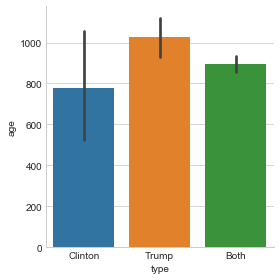

In [108]:
sb.factorplot(x='type',y='age',data=active_editor_df,kind='bar',
              order=['Clinton','Trump','Both'],hue_order=['male','female','unknown'])

In [109]:
_col = 'age'
_c = active_editor_df[active_editor_df['type'] == 'Clinton'][_col].dropna()
_t = active_editor_df[active_editor_df['type'] == 'Trump'][_col].dropna()
_b = active_editor_df[active_editor_df['type'] == 'Both'][_col].dropna()

clinton_trump_col_H,clinton_trump_col_p = stats.kruskal(_c,_t)
print("Clinton {0:.2f} ± {1:.1f}".format(_c.mean(),_c.std()))
print("Trump {0:.2f} ± {1:.1f}".format(_t.mean(),_t.std()))
print("Clinton-Trump difference: H = {0:.2f}, p = {1:.4}\n".format(clinton_trump_col_H,clinton_trump_col_p))

clinton_both_col_H,clinton_both_col_p = stats.kruskal(_c,_b)
print("Clinton {0:.2f} ± {1:.1f}".format(_c.mean(),_c.std()))
print("Both {0:.2f} ± {1:.1f}".format(_b.mean(),_b.std()))
print("Clinton-Both difference: H = {0:.2f}, p = {1:.4}\n".format(clinton_both_col_H,clinton_both_col_p))

trump_both_col_H,trump_both_col_p = stats.kruskal(_t,_b)
print("Trump {0:.2f} ± {1:.1f}".format(_t.mean(),_t.std()))
print("Both {0:.2f} ± {1:.1f}".format(_b.mean(),_b.std()))
print("Trump-Both difference: H = {0:.2f}, p = {1:.4}".format(trump_both_col_H,trump_both_col_p))

Clinton 777.83 ± 931.8
Trump 1025.08 ± 1170.4
Clinton-Trump difference: H = 1.57, p = 0.2099

Clinton 777.83 ± 931.8
Both 893.55 ± 1033.8
Clinton-Both difference: H = 1.12, p = 0.2892

Trump 1025.08 ± 1170.4
Both 893.55 ± 1033.8
Trump-Both difference: H = 1.12, p = 0.2889


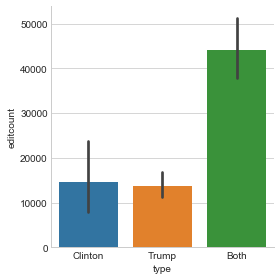

In [110]:
sb.factorplot(x='type',y='editcount',data=active_editor_df,kind='bar',
              order=['Clinton','Trump','Both'],hue_order=['male','female','unknown'])

In [111]:
_col = 'editcount'
_c = active_editor_df[active_editor_df['type'] == 'Clinton'][_col].dropna()
_t = active_editor_df[active_editor_df['type'] == 'Trump'][_col].dropna()
_b = active_editor_df[active_editor_df['type'] == 'Both'][_col].dropna()

clinton_trump_col_H,clinton_trump_col_p = stats.kruskal(_c,_t)
print("Clinton {0:.2f} ± {1:.1f}".format(_c.mean(),_c.std()))
print("Trump {0:.2f} ± {1:.1f}".format(_t.mean(),_t.std()))
print("Clinton-Trump difference: H = {0:.2f}, p = {1:.4}\n".format(clinton_trump_col_H,clinton_trump_col_p))

clinton_both_col_H,clinton_both_col_p = stats.kruskal(_c,_b)
print("Clinton {0:.2f} ± {1:.1f}".format(_c.mean(),_c.std()))
print("Both {0:.2f} ± {1:.1f}".format(_b.mean(),_b.std()))
print("Clinton-Both difference: H = {0:.2f}, p = {1:.4}\n".format(clinton_both_col_H,clinton_both_col_p))

trump_both_col_H,trump_both_col_p = stats.kruskal(_t,_b)
print("Trump {0:.2f} ± {1:.1f}".format(_t.mean(),_t.std()))
print("Both {0:.2f} ± {1:.1f}".format(_b.mean(),_b.std()))
print("Trump-Both difference: H = {0:.2f}, p = {1:.4}".format(trump_both_col_H,trump_both_col_p))

Clinton 14644.76 ± 27805.8
Trump 13787.10 ± 34025.0
Clinton-Trump difference: H = 0.00, p = 0.9701

Clinton 14644.76 ± 27805.8
Both 44104.30 ± 166617.3
Clinton-Both difference: H = 14.83, p = 0.0001175

Trump 13787.10 ± 34025.0
Both 44104.30 ± 166617.3
Trump-Both difference: H = 162.63, p = 3.013e-37


In [112]:
_c = active_editor_df[(active_editor_df['type'] == 'Clinton')]['gender'] == 'female'
_t = active_editor_df[(active_editor_df['type'] == 'Trump')]['gender'] == 'female'
_b = active_editor_df[(active_editor_df['type'] == 'Both')]['gender'] == 'female'

clinton_trump_col_H,clinton_trump_col_p = stats.kruskal(_c,_t)
print("Clinton {0:.2f} ± {1:.1f}".format(_c.mean(),_c.std()))
print("Trump {0:.2f} ± {1:.1f}".format(_t.mean(),_t.std()))
print("Clinton-Trump difference: H = {0:.2f}, p = {1:.4}\n".format(clinton_trump_col_H,clinton_trump_col_p))

clinton_both_col_H,clinton_both_col_p = stats.kruskal(_c,_b)
print("Clinton {0:.2f} ± {1:.1f}".format(_c.mean(),_c.std()))
print("Both {0:.2f} ± {1:.1f}".format(_b.mean(),_b.std()))
print("Clinton-Both difference: H = {0:.2f}, p = {1:.4}\n".format(clinton_both_col_H,clinton_both_col_p))

trump_both_col_H,trump_both_col_p = stats.kruskal(_t,_b)
print("Trump {0:.2f} ± {1:.1f}".format(_t.mean(),_t.std()))
print("Both {0:.2f} ± {1:.1f}".format(_b.mean(),_b.std()))
print("Trump-Both difference: H = {0:.2f}, p = {1:.4}".format(trump_both_col_H,trump_both_col_p))

Clinton 0.04 ± 0.2
Trump 0.03 ± 0.2
Clinton-Trump difference: H = 0.27, p = 0.6034

Clinton 0.04 ± 0.2
Both 0.03 ± 0.2
Clinton-Both difference: H = 0.18, p = 0.6677

Trump 0.03 ± 0.2
Both 0.03 ± 0.2
Trump-Both difference: H = 0.09, p = 0.7671


In [113]:
_c = active_editor_df[(active_editor_df['type'] == 'Clinton')]['blocked'] == 1
_t = active_editor_df[(active_editor_df['type'] == 'Trump')]['blocked'] == 1
_b = active_editor_df[(active_editor_df['type'] == 'Both')]['blocked'] == 1

clinton_trump_col_H,clinton_trump_col_p = stats.kruskal(_c,_t)
print("Clinton {0:.2%} ± {1:.1%}".format(_c.mean(),_c.std()))
print("Trump {0:.2%} ± {1:.1%}".format(_t.mean(),_t.std()))
print("Clinton-Trump difference: H = {0:.2%}, p = {1:.4}\n".format(clinton_trump_col_H,clinton_trump_col_p))

clinton_both_col_H,clinton_both_col_p = stats.kruskal(_c,_b)
print("Clinton {0:.2%} ± {1:.1%}".format(_c.mean(),_c.std()))
print("Both {0:.2%} ± {1:.1%}".format(_b.mean(),_b.std()))
print("Clinton-Both difference: H = {0:.2%}, p = {1:.4}\n".format(clinton_both_col_H,clinton_both_col_p))

trump_both_col_H,trump_both_col_p = stats.kruskal(_t,_b)
print("Trump {0:.2%} ± {1:.1%}".format(_t.mean(),_t.std()))
print("Both {0:.2%} ± {1:.1%}".format(_b.mean(),_b.std()))
print("Trump-Both difference: H = {0:.2%}, p = {1:.4}".format(trump_both_col_H,trump_both_col_p))

Clinton 8.70% ± 28.5%
Trump 7.79% ± 26.8%
Clinton-Trump difference: H = 4.77%, p = 0.8272

Clinton 8.70% ± 28.5%
Both 5.42% ± 22.6%
Clinton-Both difference: H = 93.62%, p = 0.3333

Trump 7.79% ± 26.8%
Both 5.42% ± 22.6%
Trump-Both difference: H = 448.88%, p = 0.03412


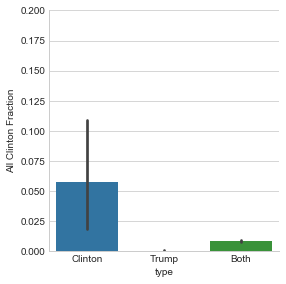

In [114]:
g = sb.factorplot(x='type',y='All Clinton Fraction',data=active_editor_df,kind='bar',
              order=['Clinton','Trump','Both'],hue_order=['male','female','unknown'])
g.set(ylim=(0,.2))

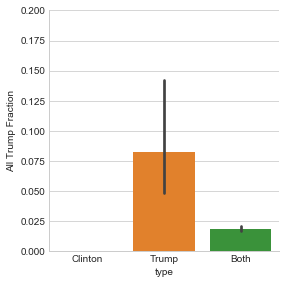

In [115]:
g = sb.factorplot(x='type',y='All Trump Fraction',data=active_editor_df,kind='bar',
              order=['Clinton','Trump','Both'],hue_order=['male','female','unknown'])
g.set(ylim=(0,.2))

In [116]:
_col = 'editcount'
_c = active_editor_df[active_editor_df['type'] == 'Clinton']['All Clinton Fraction'].dropna()
_t = active_editor_df[active_editor_df['type'] == 'Trump']['All Trump Fraction'].dropna()
_bc = active_editor_df[active_editor_df['type'] == 'Both']['All Clinton Fraction'].dropna()
_bt = active_editor_df[active_editor_df['type'] == 'Both']['All Trump Fraction'].dropna()

clinton_trump_col_F,clinton_trump_col_Fp = stats.f_oneway(_c,_t)
clinton_trump_col_H,clinton_trump_col_Hp = stats.kruskal(_c,_t)
print("Clinton {0:.2%} ± {1:.1%}".format(_c.mean(),_c.std()))
print("Trump {0:.2%} ± {1:.1%}".format(_t.mean(),_t.std()))
print("Clinton-Trump difference: H = {0:.2f}, p = {1:.3}\n".format(clinton_trump_col_H,clinton_trump_col_Hp))

both_F,both_Fp = stats.f_oneway(_bc,_bt)
both_H,both_Hp = stats.kruskal(_bc,_bt)
print("Clinton {0:.2%} ± {1:.1%}".format(_bc.mean(),_bc.std()))
print("Trump {0:.2%} ± {1:.1%}".format(_bt.mean(),_bt.std()))
print("Both Clinton-Both Trump difference: H = {0:.2f}, p = {1:.3}\n".format(both_H,both_Hp))

Clinton 5.72% ± 15.4%
Trump 8.24% ± 61.8%
Clinton-Trump difference: H = 0.03, p = 0.863

Clinton 0.83% ± 2.8%
Trump 1.89% ± 5.6%
Both Clinton-Both Trump difference: H = 78.18, p = 9.41e-19



### Predecessor and successor collaborations

In [125]:
first_edit = both_user_first_edits[both_user_first_edits['timestamp'] > pd.Timestamp('2015-01-01')]
first_edit.columns = ['first edit']
all_user_contribs = pd.merge(all_user_contribs,first_edit,left_on='user',right_index=True)
all_user_contribs['before'] = all_user_contribs['timestamp'] < all_user_contribs['first edit']
all_user_contribs['latency'] = all_user_contribs.groupby('user')['timestamp'].diff().apply(lambda x:x/np.timedelta64(1,'D'))

In [245]:
_agg = {'revid':len,'title':pd.Series.nunique,'sizediff':np.median,'ns':pd.Series.nunique,'latency':np.median,
        'timestamp':lambda x: (x.max() - x.min())/np.timedelta64(1,'D'),'date':pd.Series.nunique,'new':np.sum,
        'comment':lambda x:np.sum(x.notnull())}
before_after_agg = all_user_contribs.groupby(['user','before']).agg(_agg)
before_after_agg = before_after_agg.unstack(1).sort_index(axis=1)

# Compute entropy
user_article_beforeafter_revs = all_user_contribs.groupby(['user','before','title']).agg({'revid':len})['revid']
rev_fraction = user_article_beforeafter_revs.unstack(1).fillna(0).div(user_article_beforeafter_revs.sum(level=[0,1]).unstack(1))
entropy_stats = rev_fraction.reset_index().groupby('user').agg({False:stats.entropy,True:stats.entropy})

before_after_agg[('entropy',False)] = entropy_stats[False]
before_after_agg[('entropy',True)] = entropy_stats[True]

before_after_agg.head()

comment          date         latency              new         \
before         False  True   False True      False     True   False  True    
user                                                                         
-glove-       2071.0  477.0  110.0  18.0  0.000370  0.000990  393.0  105.0   
0xF8E8        6749.0  171.0  300.0  92.0  0.000694  0.210509  437.0   12.0   
11 Arlington   140.0  214.0   75.0  90.0  0.654630  0.007303    0.0    1.0   
11Eternity11    30.0   44.0    3.0   5.0  0.008003  0.012141    0.0    1.0   
127W111       4455.0  338.0  201.0  50.0  0.004329  0.005220    1.0    0.0   

                ns         revid        sizediff          timestamp  \
before       False True    False  True     False  True        False   
user                                                                  
-glove-       10.0   6.0  2088.0  513.0    116.5   76.0  419.420822   
0xF8E8        12.0   9.0  6874.0  200.0      1.0   33.0  629.739525   
11 Arlington   2.0   3.0   151.0  262.0      6.0    4.0  651.096007   
11Eternity11   4.0   2.0    32.0   45.0    303.5  338.0    1.924942   
127W111        4.0   3.0  4468.0  342.0      2.0    0.0  252.437766   

                           title          entropy            
before             True    False  True      False     True   
user                                                         
-glove-        59.882488  1556.0  329.0  7.092238  5.471321  
0xF8E8        590.664329  5867.0   95.0  8.513509  3.860003  
11 Arlington  794.068414    93.0  119.0  4.370982  4.484220  
11Eternity11    4.992049    10.0    4.0  1.959248  0.392379  
127W111        98.900671   556.0  121.0  2.982068  4.017254

In [271]:
len(all_user_contribs['user'].unique())

1075

In [272]:
stats_d = {}

for _var in sorted(before_after_agg.columns.levels[0]):
    _before = before_after_agg.loc[:,idx[_var,1]].replace({-np.inf:np.nan}).dropna()
    _after = before_after_agg.loc[:,idx[_var,0]].replace({-np.inf:np.nan}).dropna()

    F,p_F = stats.f_oneway(_before,_after)
    H,p_H = stats.kruskal(_before,_after)
    
    print("\n-------------\n{0}\n-------------".format(_var))
    print("Before mean: {0:.2f} ± {1:.1f}\nAfter mean : {2:.2f} ± {3:.1f}\nANOVA F: {4:.2f} (p = {5:.3f})\nKruskal H: {6:.1f} (p = {7:.3f})".format(_before.mean(),_before.std(),_after.mean(),_after.std(),F,p_F,H,p_H))
    stats_d[_var] = {}
    
    if _before.mean() >= 100 or _after.mean() >= 100:
        stats_d[_var]['Before'] = '{0:.0f} ± {1:.0f}'.format(_before.mean(),_before.std())
        stats_d[_var]['After'] = '{0:.0f} ± {1:.0f}'.format(_after.mean(),_after.std())
    else:
        stats_d[_var]['Before'] = '{0:.2f} ± {1:.2f}'.format(_before.mean(),_before.std())
        stats_d[_var]['After'] = '{0:.2f} ± {1:.2f}'.format(_after.mean(),_after.std())
    
    if p_H >= 0.01 and p_H < 0.05:
        stats_d[_var]['H-test'] = '{0:.1f}*'.format(H)
    elif p_H >= 0.001 and p_H < 0.001:
        stats_d[_var]['H-test'] = '{0:.1f}**'.format(H)
    elif p_H < 0.001:
        stats_d[_var]['H-test'] = '{0:.1f}***'.format(H)
    else:
        stats_d[_var]['H-test'] = '{0:.1f}'.format(H)


-------------
comment
-------------
Before mean: 1851.68 ± 5293.7
After mean : 5399.38 ± 11952.0
ANOVA F: 78.50 (p = 0.000)
Kruskal H: 215.4 (p = 0.000)

-------------
date
-------------
Before mean: 153.16 ± 181.0
After mean : 263.52 ± 213.7
ANOVA F: 165.38 (p = 0.000)
Kruskal H: 246.8 (p = 0.000)

-------------
entropy
-------------
Before mean: 4.68 ± 1.8
After mean : 5.89 ± 1.8
ANOVA F: 234.86 (p = 0.000)
Kruskal H: 198.5 (p = 0.000)

-------------
latency
-------------
Before mean: 0.39 ± 5.4
After mean : 0.11 ± 1.5
ANOVA F: 2.81 (p = 0.094)
Kruskal H: 24.0 (p = 0.000)

-------------
new
-------------
Before mean: 183.13 ± 1436.7
After mean : 496.70 ± 1621.8
ANOVA F: 22.31 (p = 0.000)
Kruskal H: 77.4 (p = 0.000)

-------------
ns
-------------
Before mean: 6.48 ± 3.6
After mean : 8.38 ± 4.2
ANOVA F: 122.38 (p = 0.000)
Kruskal H: 103.8 (p = 0.000)

-------------
revid
-------------
Before mean: 2186.62 ± 5771.7
After mean : 5979.93 ± 12478.8
ANOVA F: 81.12 (p = 0.000)
Kruskal H: 2

In [259]:
print(pd.DataFrame(stats_d).T[['Before','After','H-test']].to_latex())

\begin{tabular}{llll}
\toprule
{} &          Before &           After &    H-test \\
\midrule
comment   &     1852 ± 5294 &    5399 ± 11952 &  215.4*** \\
date      &       153 ± 181 &       264 ± 214 &  246.8*** \\
entropy   &     4.68 ± 1.80 &     5.89 ± 1.83 &  198.5*** \\
latency   &     0.39 ± 5.36 &     0.11 ± 1.46 &   24.0*** \\
new       &      183 ± 1437 &      497 ± 1622 &   77.4*** \\
ns        &     6.48 ± 3.62 &     8.38 ± 4.25 &  103.8*** \\
revid     &     2187 ± 5772 &    5980 ± 12479 &  226.3*** \\
sizediff  &  69.69 ± 384.81 &  60.40 ± 125.09 &       0.7 \\
timestamp &       483 ± 352 &       543 ± 260 &   22.9*** \\
title     &      944 ± 4098 &     3096 ± 8033 &  217.5*** \\
\bottomrule
\end{tabular}

